# Prediksi Permintaan Berbagi Sepeda Menggunakan Scikit-learn & XGBoost

**Dibuat oleh: COGNIDATA**

**Tujuan Proyek:**
Membuat model machine learning untuk memprediksi jumlah total sepeda yang akan disewa dalam satu jam tertentu berdasarkan fitur-fitur historis seperti waktu, musim, dan kondisi cuaca. Model ini akan dibangun, dievaluasi, dan disimpan menggunakan Scikit-learn dan XGBoost agar dapat di-deploy di aplikasi Streamlit dengan dependensi minimal.

**Daftar Isi:**
1.  Instalasi dan Impor Library
2.  Pemuatan Data
3.  Analisis Data Eksploratif (EDA) - Lengkap
    * 3.1. Informasi Dasar dan Statistik Deskriptif
    * 3.2. Ekstraksi Fitur Waktu untuk EDA
    * 3.3. Analisis Variabel Target (`count`)
    * 3.4. Analisis Fitur Numerik
    * 3.5. Analisis Fitur Kategorikal
    * 3.6. Analisis Hubungan Fitur dengan Target
    * 3.7. Analisis Tren Waktu
    * 3.8. Kesimpulan EDA dan Langkah Selanjutnya
4.  Pra-pemrosesan Data dan Rekayasa Fitur
5.  Definisi Pipeline Pra-pemrosesan dengan `ColumnTransformer`
6.  Perbandingan Model Dasar (Manual)
7.  Pemilihan dan Pelatihan Model Terbaik (dengan Pencarian Hyperparameter)
8.  Evaluasi Model Final
9.  Penyimpanan Model (Pipeline Lengkap)

Instalasi Library

In [1]:
# Instalasi library yang mungkin belum ada di Colab atau untuk memastikan versi
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn

Instalasi Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime # Berguna untuk EDA
import io # Untuk fungsi upload

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error

# XGBoost
import xgboost as xgb

# Untuk mengunduh file dari Colab
from google.colab import files

# Pengaturan umum
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-pastel')

Pemuatan Data

In [3]:
# Fungsi untuk mengunggah dan membaca file CSV
def upload_and_read_csv(file_prompt):
    """Meminta pengguna mengunggah file CSV dan membacanya ke dalam DataFrame Pandas."""
    print(file_prompt)
    uploaded = files.upload()
    if not uploaded:
        print("Tidak ada file yang diunggah.")
        return None
    file_name = list(uploaded.keys())[0]
    print(f"File '{file_name}' berhasil diunggah.")
    try:
        df = pd.read_csv(io.BytesIO(uploaded[file_name]), parse_dates=['datetime'])
        print(f"DataFrame berhasil dibuat dari '{file_name}'.")
        return df
    except Exception as e:
        print(f"Error saat membaca file CSV '{file_name}': {e}")
        return None

# Mengunggah dan membaca file train.csv
df_train_raw = upload_and_read_csv("Silakan unggah file train.csv")

# Mengunggah dan membaca file test.csv (untuk struktur prediksi akhir jika diperlukan)
df_test_raw = upload_and_read_csv("Silakan unggah file test.csv")

if df_train_raw is not None:
    print("\nBeberapa baris pertama dari df_train_raw:")
    display(df_train_raw.head())
    print(f"Bentuk df_train_raw: {df_train_raw.shape}")

if df_test_raw is not None:
    print("\nBeberapa baris pertama dari df_test_raw:")
    display(df_test_raw.head())
    print(f"Bentuk df_test_raw: {df_test_raw.shape}")

Silakan unggah file train.csv


Saving train.csv to train.csv
File 'train.csv' berhasil diunggah.
DataFrame berhasil dibuat dari 'train.csv'.
Silakan unggah file test.csv


Saving test.csv to test.csv
File 'test.csv' berhasil diunggah.
DataFrame berhasil dibuat dari 'test.csv'.

Beberapa baris pertama dari df_train_raw:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Bentuk df_train_raw: (10886, 12)

Beberapa baris pertama dari df_test_raw:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


Bentuk df_test_raw: (6493, 9)


## 3. Analisis Data Eksploratif (EDA) - Lengkap

Pada tahap ini, kita akan melakukan analisis mendalam terhadap data untuk memahami karakteristik, distribusi, dan hubungan antar variabel.

3.1. Informasi Dasar dan Statistik Deskriptif

In [4]:
if df_train_raw is not None:
    print("Informasi Dataset Latih (df_train_raw):")
    df_train_raw.info()
    print("\n" + "="*50 + "\n")

    print("Statistik Deskriptif Dataset Latih (df_train_raw):")
    display(df_train_raw.describe(include='all')) # datetime_is_numeric sudah dihapus
    print("\n" + "="*50 + "\n")

    print("Persentase Nilai Hilang di Dataset Latih (df_train_raw):")
    missing_values = df_train_raw.isnull().sum() / len(df_train_raw) * 100
    display(missing_values[missing_values > 0].sort_values(ascending=False))
    if missing_values.sum() == 0:
        print("Tidak ada nilai hilang di dataset latih.")
    else:
        # Jika ada missing values, tambahkan rencana penanganannya di sini (misal: imputasi)
        pass
    print("\n" + "="*50 + "\n")

    print(f"Jumlah Baris Duplikat di df_train_raw: {df_train_raw.duplicated().sum()}")
    if df_train_raw.duplicated().sum() > 0:
        # Jika ada duplikat, tambahkan rencana penanganannya (misal: drop)
        pass
    print("\n" + "="*50 + "\n")

    # Tipe data unik
    print("Tipe Data Unik di df_train_raw:")
    display(df_train_raw.dtypes.value_counts())
    print("\n" + "="*50 + "\n")
else:
    print("df_train_raw belum dimuat. Jalankan sel pemuatan data terlebih dahulu.")

Informasi Dataset Latih (df_train_raw):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


Statistik Deskriptif Dataset Latih (df_train_raw):


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454




Persentase Nilai Hilang di Dataset Latih (df_train_raw):


,0


Tidak ada nilai hilang di dataset latih.


Jumlah Baris Duplikat di df_train_raw: 0


Tipe Data Unik di df_train_raw:


,count
int64,8
float64,3
datetime64[ns],1


Wawasan dari Sel 6:

Dataset latih terdiri dari 10886 baris dan 12 kolom.
Kolom datetime sudah benar dibaca sebagai tipe datetime.
Fitur lainnya mayoritas bertipe integer dan float.
Tidak ada nilai hilang (missing values) yang terdeteksi di dataset latih.
Tidak ada baris duplikat yang terdeteksi.
Ini menunjukkan data awal cukup bersih dari sisi missing values dan duplikasi.

3.2. Ekstraksi Fitur Waktu untuk EDA

In [5]:
if df_train_raw is not None:
    df_eda = df_train_raw.copy()
    df_eda['hour'] = df_eda['datetime'].dt.hour
    df_eda['dayofweek'] = df_eda['datetime'].dt.dayofweek # Senin=0, Minggu=6
    df_eda['day_name'] = df_eda['datetime'].dt.day_name()
    df_eda['month'] = df_eda['datetime'].dt.month
    df_eda['month_name'] = df_eda['datetime'].dt.month_name()
    df_eda['year'] = df_eda['datetime'].dt.year
    df_eda['day'] = df_eda['datetime'].dt.day
    df_eda['date_only'] = df_eda['datetime'].dt.date # Untuk agregasi harian

    print("Fitur waktu berhasil diekstrak untuk EDA.")
    display(df_eda.head())
else:
    print("df_train_raw belum dimuat.")

Fitur waktu berhasil diekstrak untuk EDA.


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek,day_name,month,month_name,year,day,date_only
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,Saturday,1,January,2011,1,2011-01-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,Saturday,1,January,2011,1,2011-01-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,Saturday,1,January,2011,1,2011-01-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,Saturday,1,January,2011,1,2011-01-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,Saturday,1,January,2011,1,2011-01-01


3.3. Analisis Variabel Target (count)

Skewness 'count': 1.24
Kurtosis 'count': 1.30
Skewness Log(count + 1): -0.85
Kurtosis Log(count + 1): -0.12


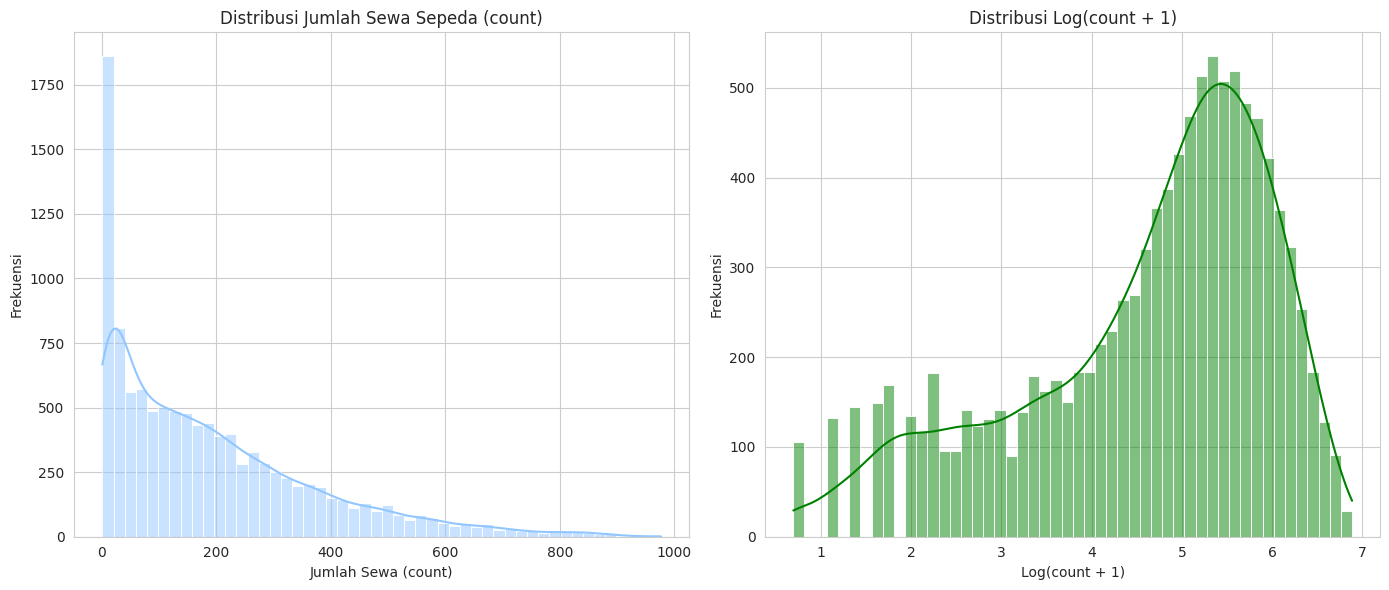

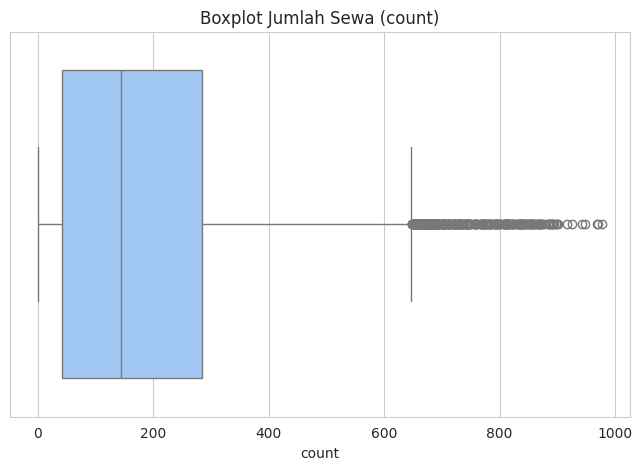

In [6]:
if 'df_eda' in locals():
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df_eda['count'], kde=True, bins=50)
    plt.title('Distribusi Jumlah Sewa Sepeda (count)')
    plt.xlabel('Jumlah Sewa (count)')
    plt.ylabel('Frekuensi')
    skew_count = df_eda['count'].skew()
    kurt_count = df_eda['count'].kurtosis()
    print(f"Skewness 'count': {skew_count:.2f}")
    print(f"Kurtosis 'count': {kurt_count:.2f}")

    plt.subplot(1, 2, 2)
    y_log_transformed = np.log1p(df_eda['count'])
    sns.histplot(y_log_transformed, kde=True, bins=50, color='green')
    plt.title('Distribusi Log(count + 1)')
    plt.xlabel('Log(count + 1)')
    plt.ylabel('Frekuensi')
    skew_log_count = y_log_transformed.skew()
    kurt_log_count = y_log_transformed.kurtosis()
    print(f"Skewness Log(count + 1): {skew_log_count:.2f}")
    print(f"Kurtosis Log(count + 1): {kurt_log_count:.2f}")

    plt.tight_layout()
    plt.show()

    # Boxplot untuk melihat outliers
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_eda['count'])
    plt.title('Boxplot Jumlah Sewa (count)')
    plt.show()
else:
    print("df_eda belum dibuat. Jalankan sel ekstraksi fitur waktu terlebih dahulu.")

Wawasan dari Sel 8:

Distribusi variabel target count sangat miring ke kanan (positive skewness), dengan nilai skewness sekitar 1.24. Ini menunjukkan bahwa sebagian besar data terkonsentrasi pada nilai count yang rendah, dengan beberapa nilai tinggi yang jarang terjadi (ekor panjang ke kanan).
Setelah transformasi logaritmik (np.log1p), distribusi menjadi lebih simetris dan mendekati normal, dengan skewness berkurang menjadi -0.85. Transformasi ini kemungkinan akan bermanfaat untuk model regresi linear atau model lain yang sensitif terhadap distribusi data.
Boxplot dari count asli menunjukkan adanya banyak pencilan (outliers) di sisi atas, yang mengkonfirmasi kemiringan positif.

3.4. Analisis Fitur Numerik


Statistik Deskriptif Fitur Numerik:


,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


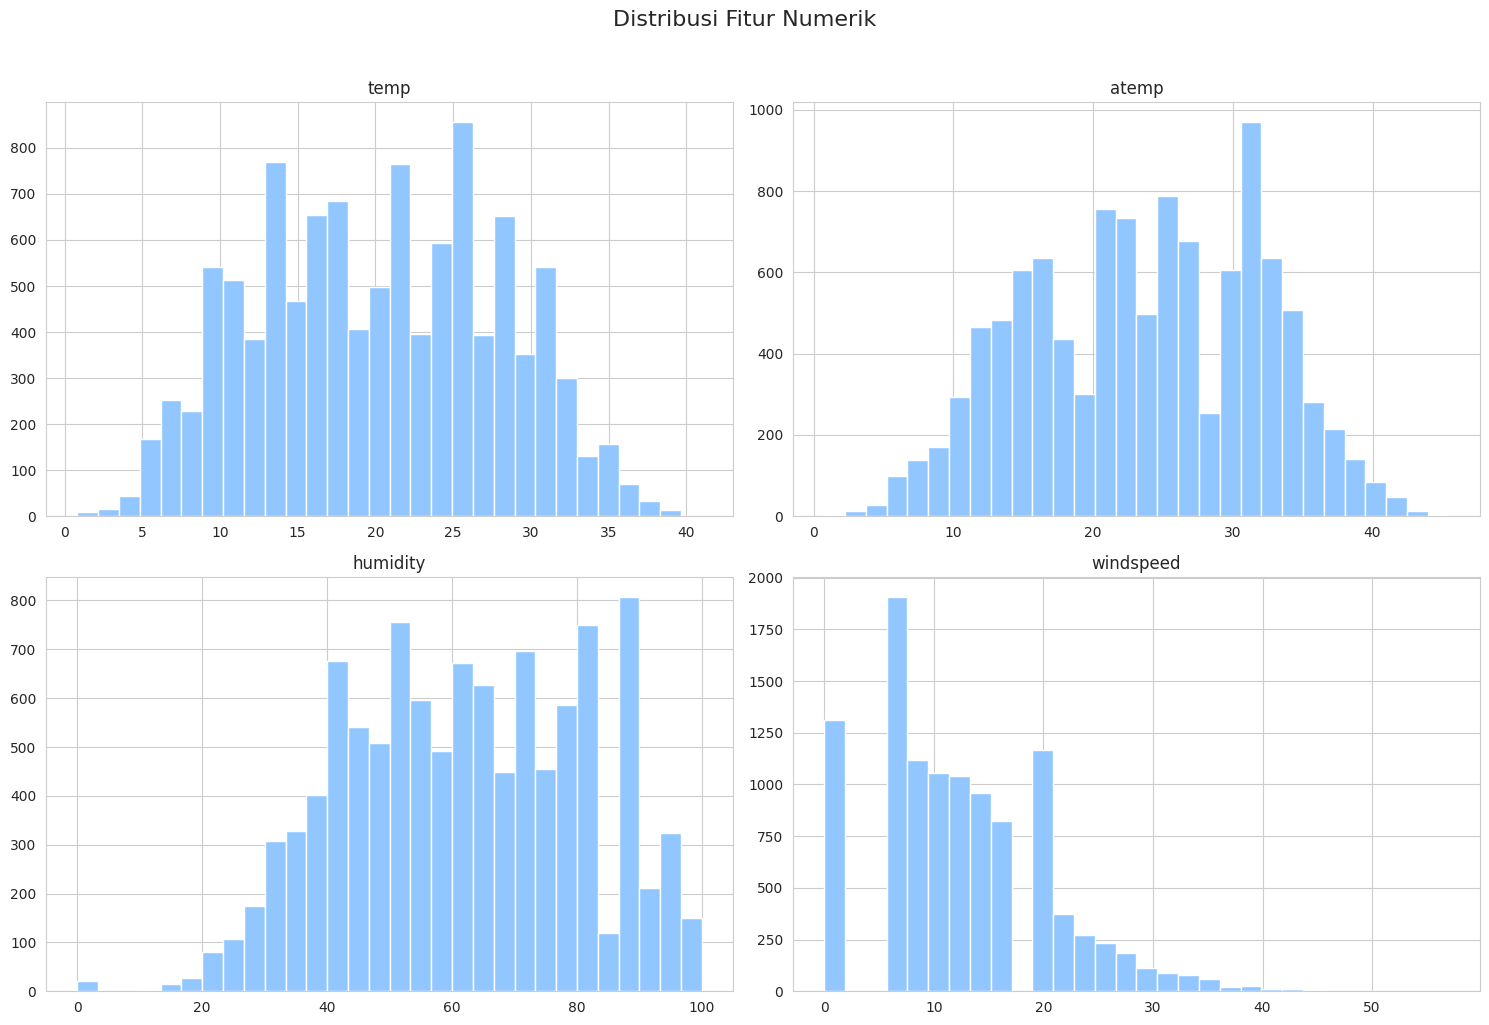

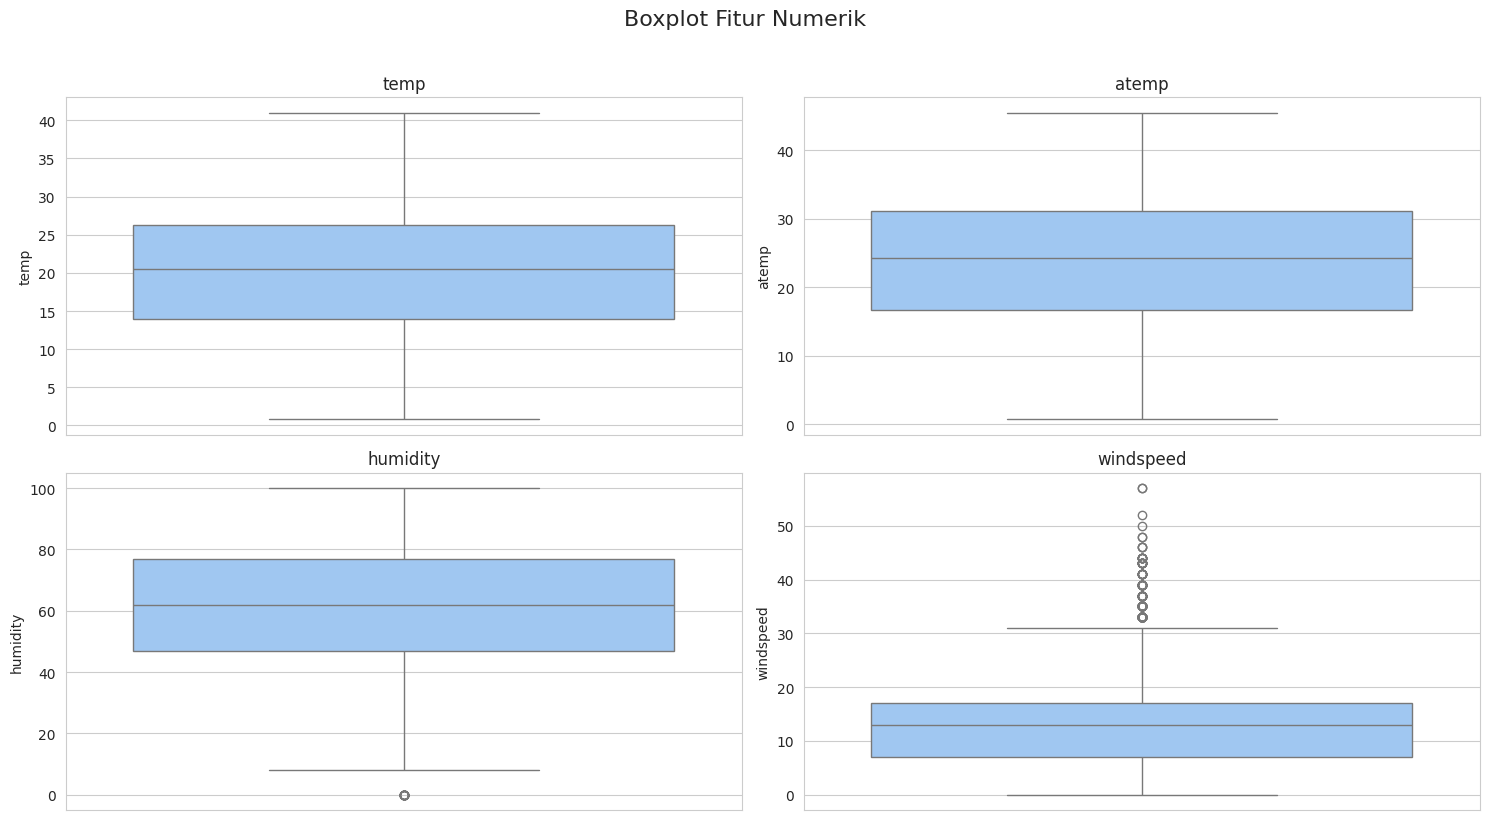

In [7]:
if 'df_eda' in locals():
    numerical_features_eda = ['temp', 'atemp', 'humidity', 'windspeed'] # 'atemp' masih diikutkan untuk EDA awal

    print("\nStatistik Deskriptif Fitur Numerik:")
    display(df_eda[numerical_features_eda].describe())

    df_eda[numerical_features_eda].hist(bins=30, figsize=(15, 10), layout=(2, 2))
    plt.suptitle("Distribusi Fitur Numerik", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Boxplot untuk fitur numerik untuk melihat outliers
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(numerical_features_eda):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(y=df_eda[col])
        plt.title(col)
    plt.suptitle("Boxplot Fitur Numerik", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("df_eda belum dibuat.")

Wawasan dari Sel 9:

temp (suhu aktual) dan atemp (suhu terasa) memiliki distribusi yang mirip dan sangat berkorelasi (akan kita lihat di heatmap nanti). Ini mengindikasikan salah satunya mungkin bisa dihapus untuk menghindari multikolinearitas.
humidity (kelembapan) memiliki beberapa nilai 0 yang tampak aneh dan perlu diselidiki. Distribusinya cukup menyebar dari nilai rendah hingga 100%.
windspeed (kecepatan angin) memiliki konsentrasi nilai yang signifikan pada angka 0. Ini bisa berarti angin benar-benar 0 atau data tidak tercatat/hilang dan diisi dengan 0. Ini perlu diperhatikan saat pra-pemrosesan (misalnya, winsorizing atau imputasi). Distribusinya juga miring ke kanan dengan beberapa pencilan di nilai tinggi.
Boxplot mengkonfirmasi adanya pencilan pada humidity (nilai 0) dan windspeed (nilai tinggi).

3.5. Analisis Fitur Kategorikal

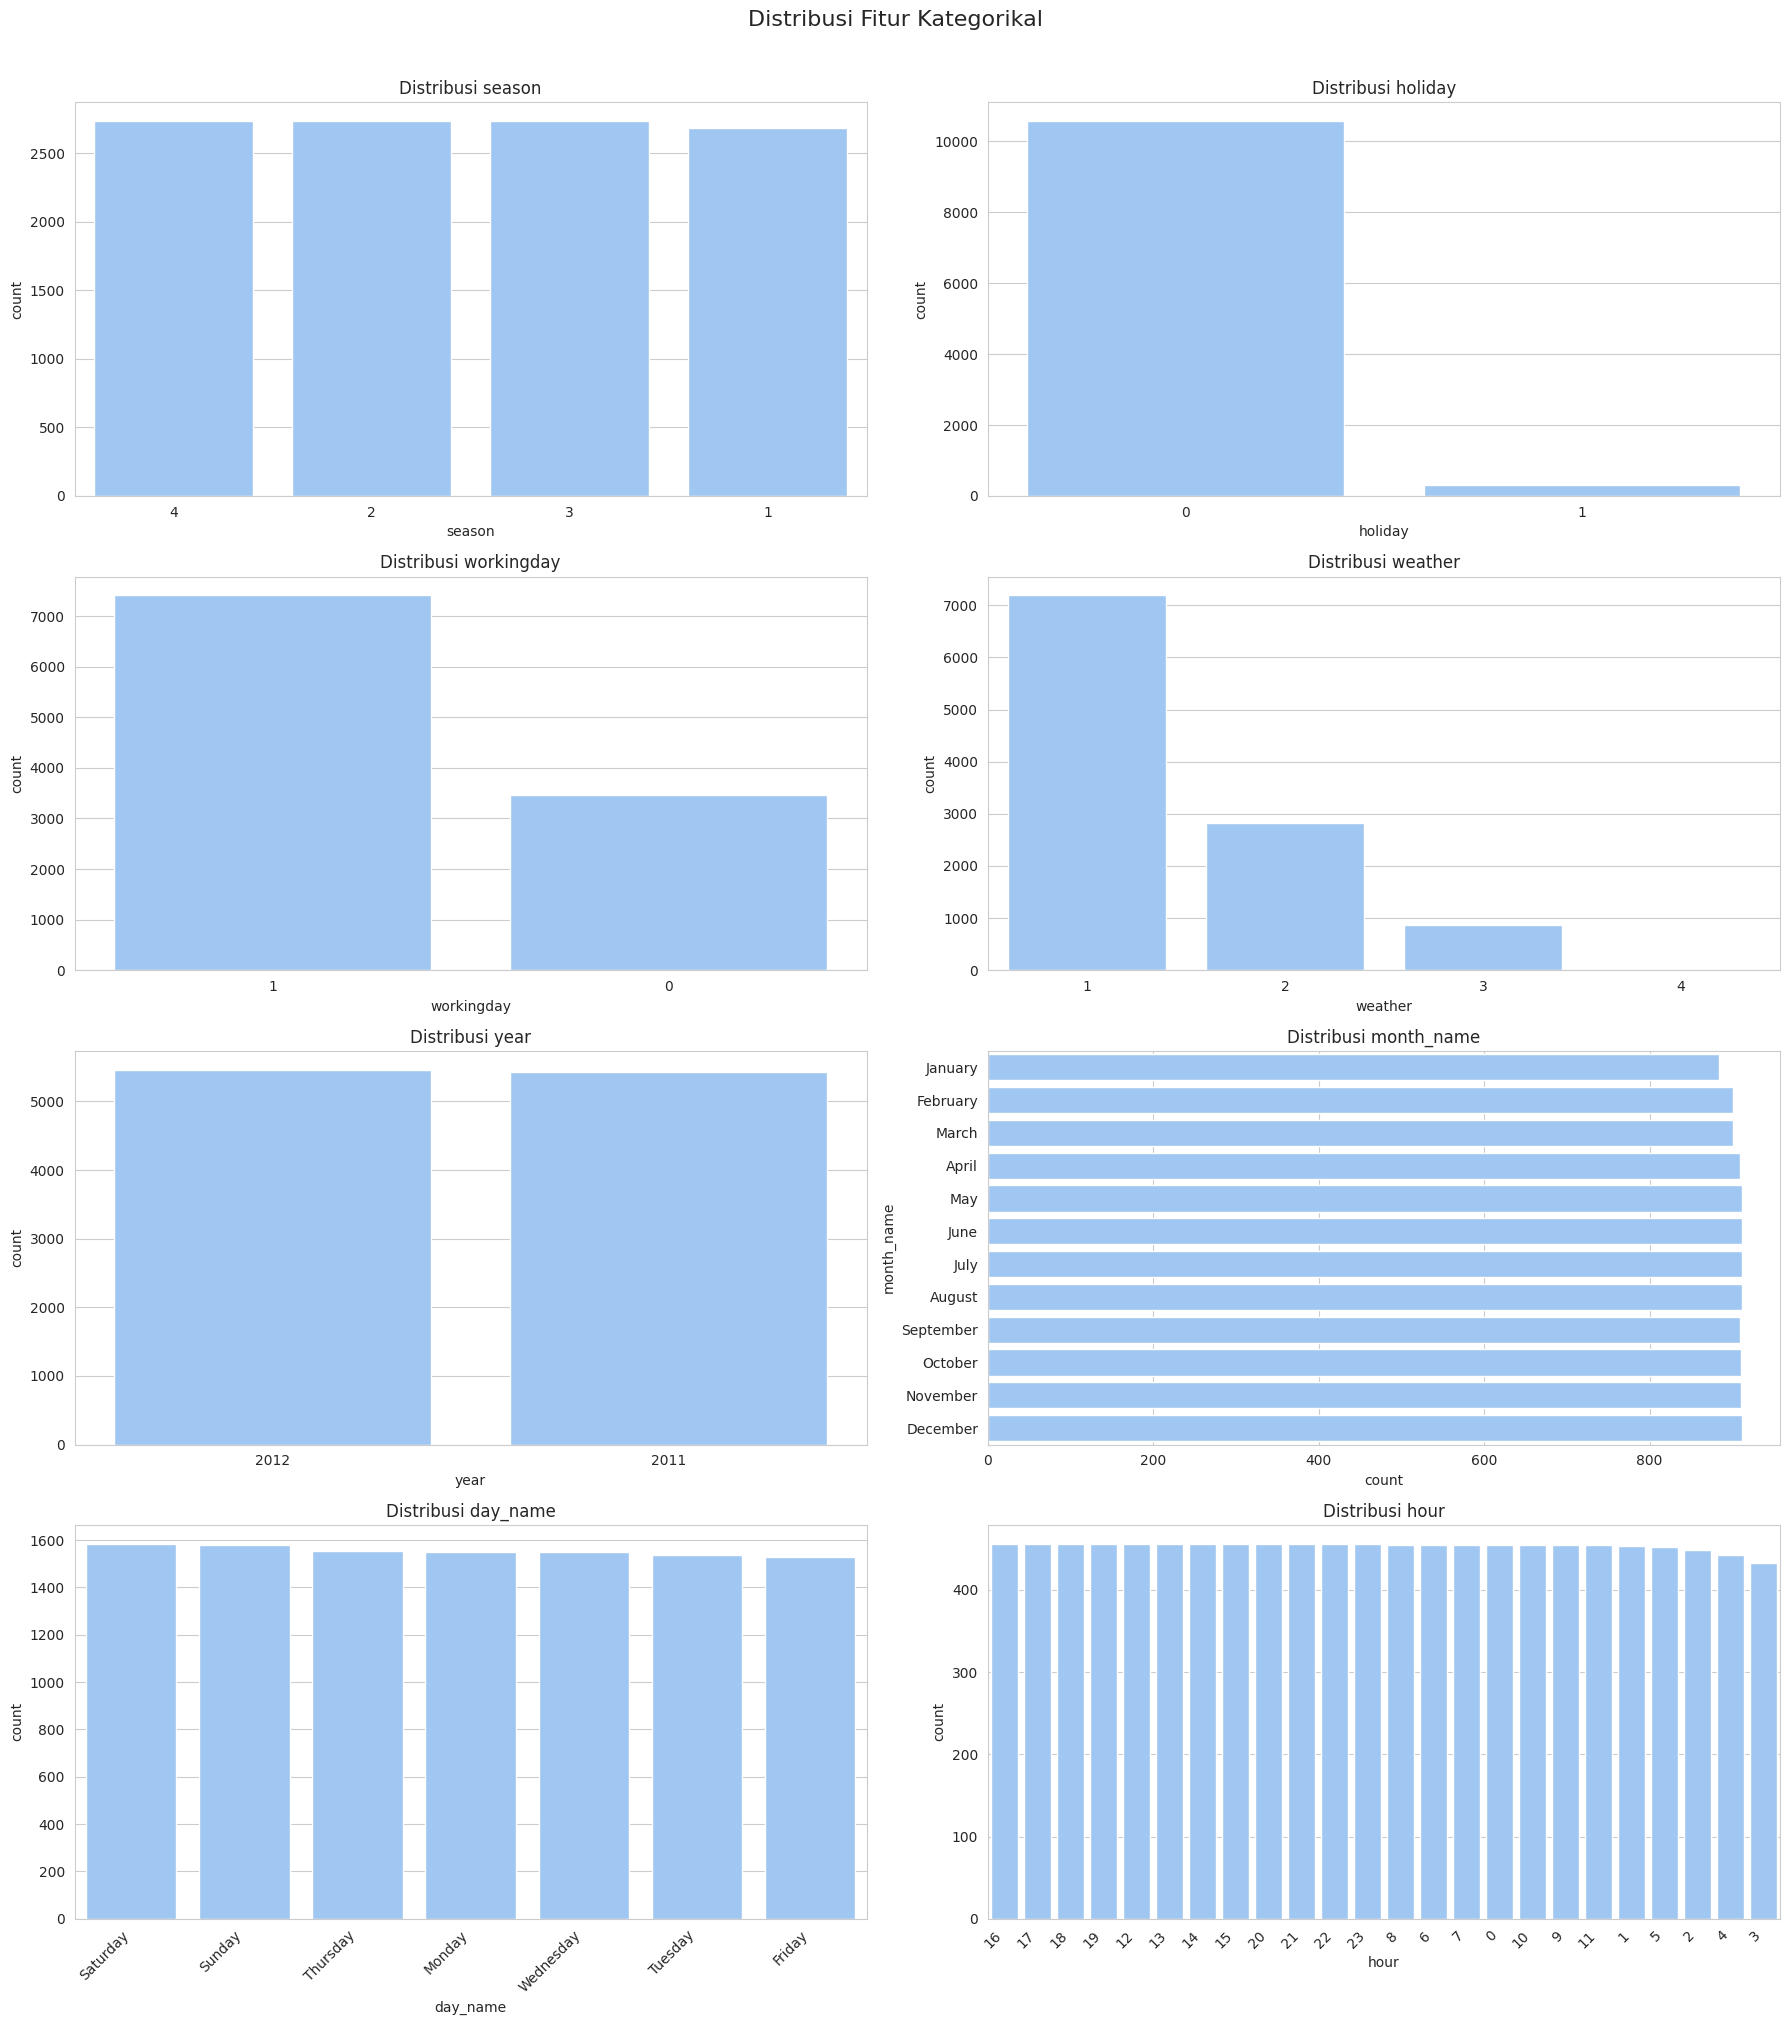

In [8]:
if 'df_eda' in locals():
    categorical_features_eda = ['season', 'holiday', 'workingday', 'weather',
                                'year', 'month_name', 'day_name', 'hour']

    plt.figure(figsize=(18, 20))
    for i, col in enumerate(categorical_features_eda):
        plt.subplot(4, 2, i + 1)
        order = df_eda[col].value_counts().index
        if df_eda[col].nunique() > 10 and col not in ['hour']: # Untuk 'month_name' dan 'day_name' yang diurutkan
             if col == 'day_name':
                order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
             elif col == 'month_name':
                order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
             sns.countplot(y=col, data=df_eda, order=order)
        else:
            sns.countplot(x=col, data=df_eda, order=order)
            if df_eda[col].nunique() > 5 : # Rotasi jika banyak kategori di sumbu x
                 plt.xticks(rotation=45, ha='right')
        plt.title(f'Distribusi {col}')
    plt.suptitle("Distribusi Fitur Kategorikal", y=1.01, fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("df_eda belum dibuat.")

Wawasan dari Sel 10:

season: Distribusi keempat musim tampak relatif seimbang.
holiday: Jumlah hari libur jauh lebih sedikit dibandingkan hari non-libur.
workingday: Jumlah hari kerja lebih banyak daripada hari non-kerja (akhir pekan/libur).
weather: Kondisi cuaca 1 (cerah/sedikit berawan) paling dominan, diikuti cuaca 2 (kabut/berawan), dan cuaca 3 (hujan/salju ringan). Cuaca 4 (ekstrem) sangat jarang, yang mungkin menyulitkan model untuk mempelajarinya.
year: Data berasal dari dua tahun, 2011 dan 2012, dengan jumlah sampel yang hampir sama.
month_name, day_name, hour: Menunjukkan variasi yang diharapkan dan akan penting untuk menangkap pola temporal.

3.6. Analisis Hubungan Fitur dengan Target

Fitur Numerik vs Target

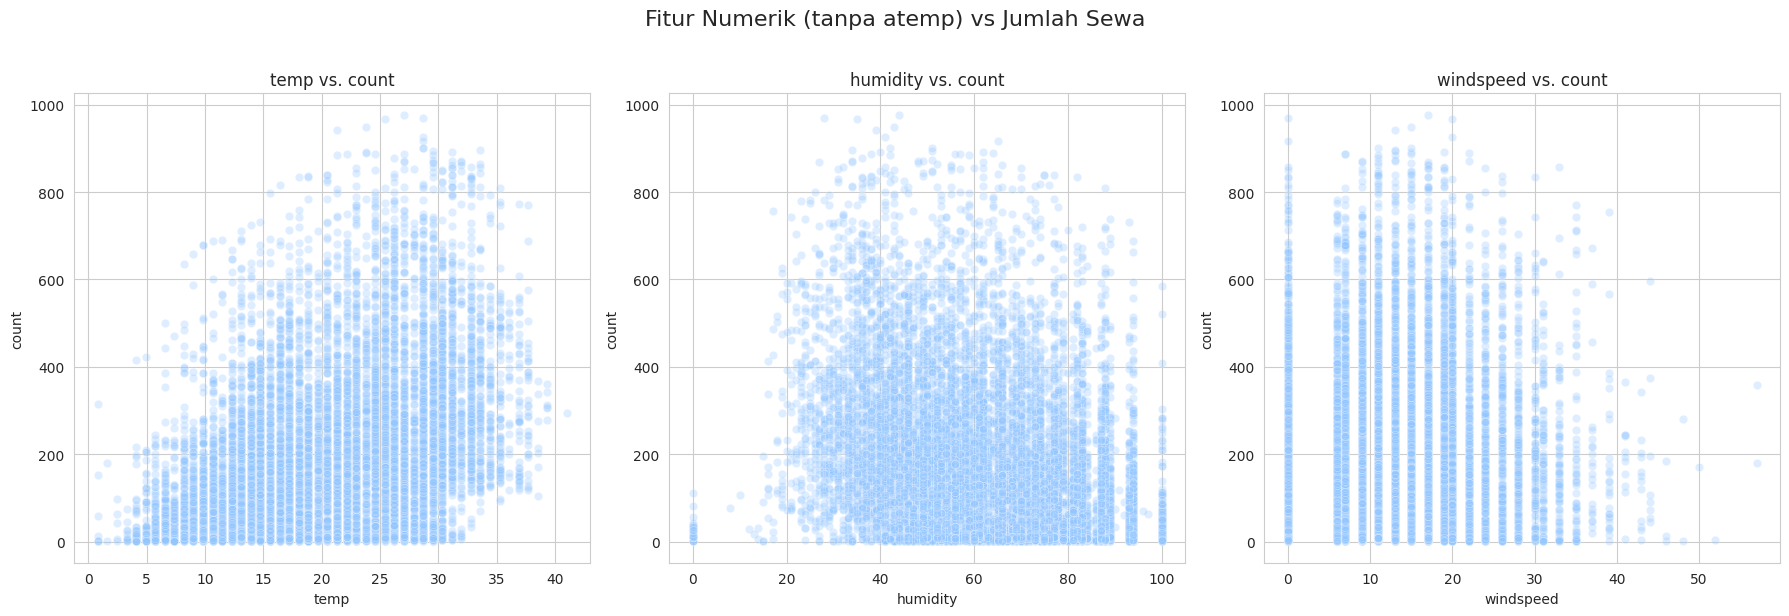

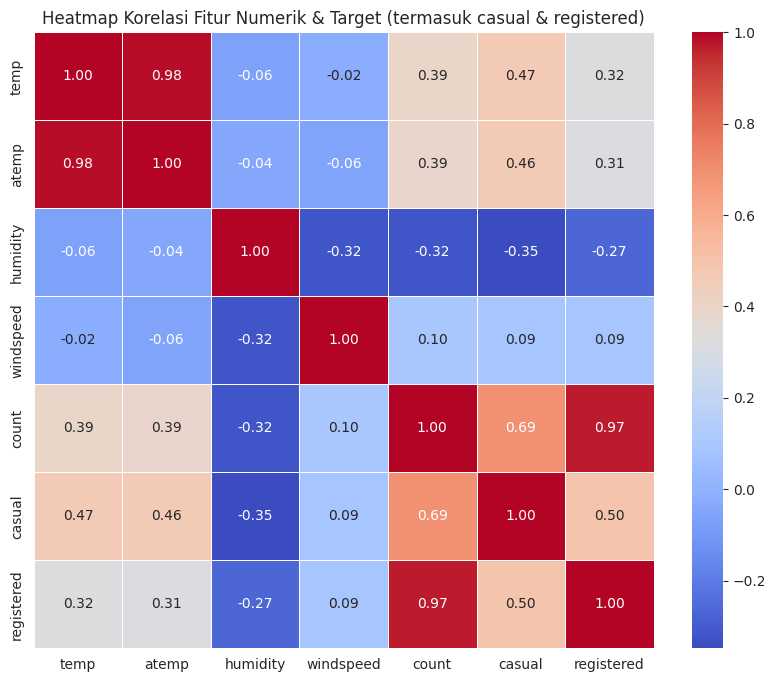

In [9]:
if 'df_eda' in locals():
    numerical_features_eda_no_atemp = ['temp', 'humidity', 'windspeed'] # atemp dihilangkan karena korelasi tinggi dengan temp

    plt.figure(figsize=(18, 6)) # Ukuran disesuaikan untuk 3 plot
    for i, col in enumerate(numerical_features_eda_no_atemp):
        plt.subplot(1, 3, i + 1)
        sns.scatterplot(x=df_eda[col], y=df_eda['count'], alpha=0.3)
        plt.title(f'{col} vs. count')
    plt.suptitle("Fitur Numerik (tanpa atemp) vs Jumlah Sewa", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Korelasi Pearson
    # Sertakan 'atemp' untuk melihat korelasinya, lalu bisa dipertimbangkan untuk di-drop
    correlation_matrix_num_target = df_eda[numerical_features_eda + ['count', 'casual', 'registered']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_num_target, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Heatmap Korelasi Fitur Numerik & Target (termasuk casual & registered)')
    plt.show()
else:
    print("df_eda belum dibuat.")

Wawasan dari Sel 11 (Numerik):

Scatter plot menunjukkan adanya hubungan positif antara temp dengan count. Saat suhu meningkat, jumlah sewa cenderung meningkat hingga titik tertentu.
humidity tampaknya memiliki hubungan negatif ringan dengan count; kelembapan yang sangat tinggi mungkin mengurangi minat bersepeda.
windspeed juga menunjukkan hubungan negatif ringan, di mana kecepatan angin yang tinggi cenderung menurunkan jumlah sewa.
Heatmap korelasi mengkonfirmasi:
Korelasi positif kuat antara temp dan count (0.39).
Korelasi sangat tinggi antara temp dan atemp (0.98), memvalidasi keputusan untuk menghapus atemp.
Korelasi negatif sedang antara humidity dan count (-0.32).
Korelasi positif ringan antara windspeed dan count (0.10), yang mungkin sedikit bertentangan dengan scatter plot awal dan perlu eksplorasi lebih lanjut (mungkin ada efek non-linear atau interaksi).
casual dan registered sangat berkorelasi positif dengan count (karena count adalah jumlah keduanya), dan juga memiliki korelasi yang berbeda dengan fitur cuaca, yang menarik tetapi tidak akan digunakan sebagai prediktor langsung untuk count.

Fitur Kategorikal vs Target

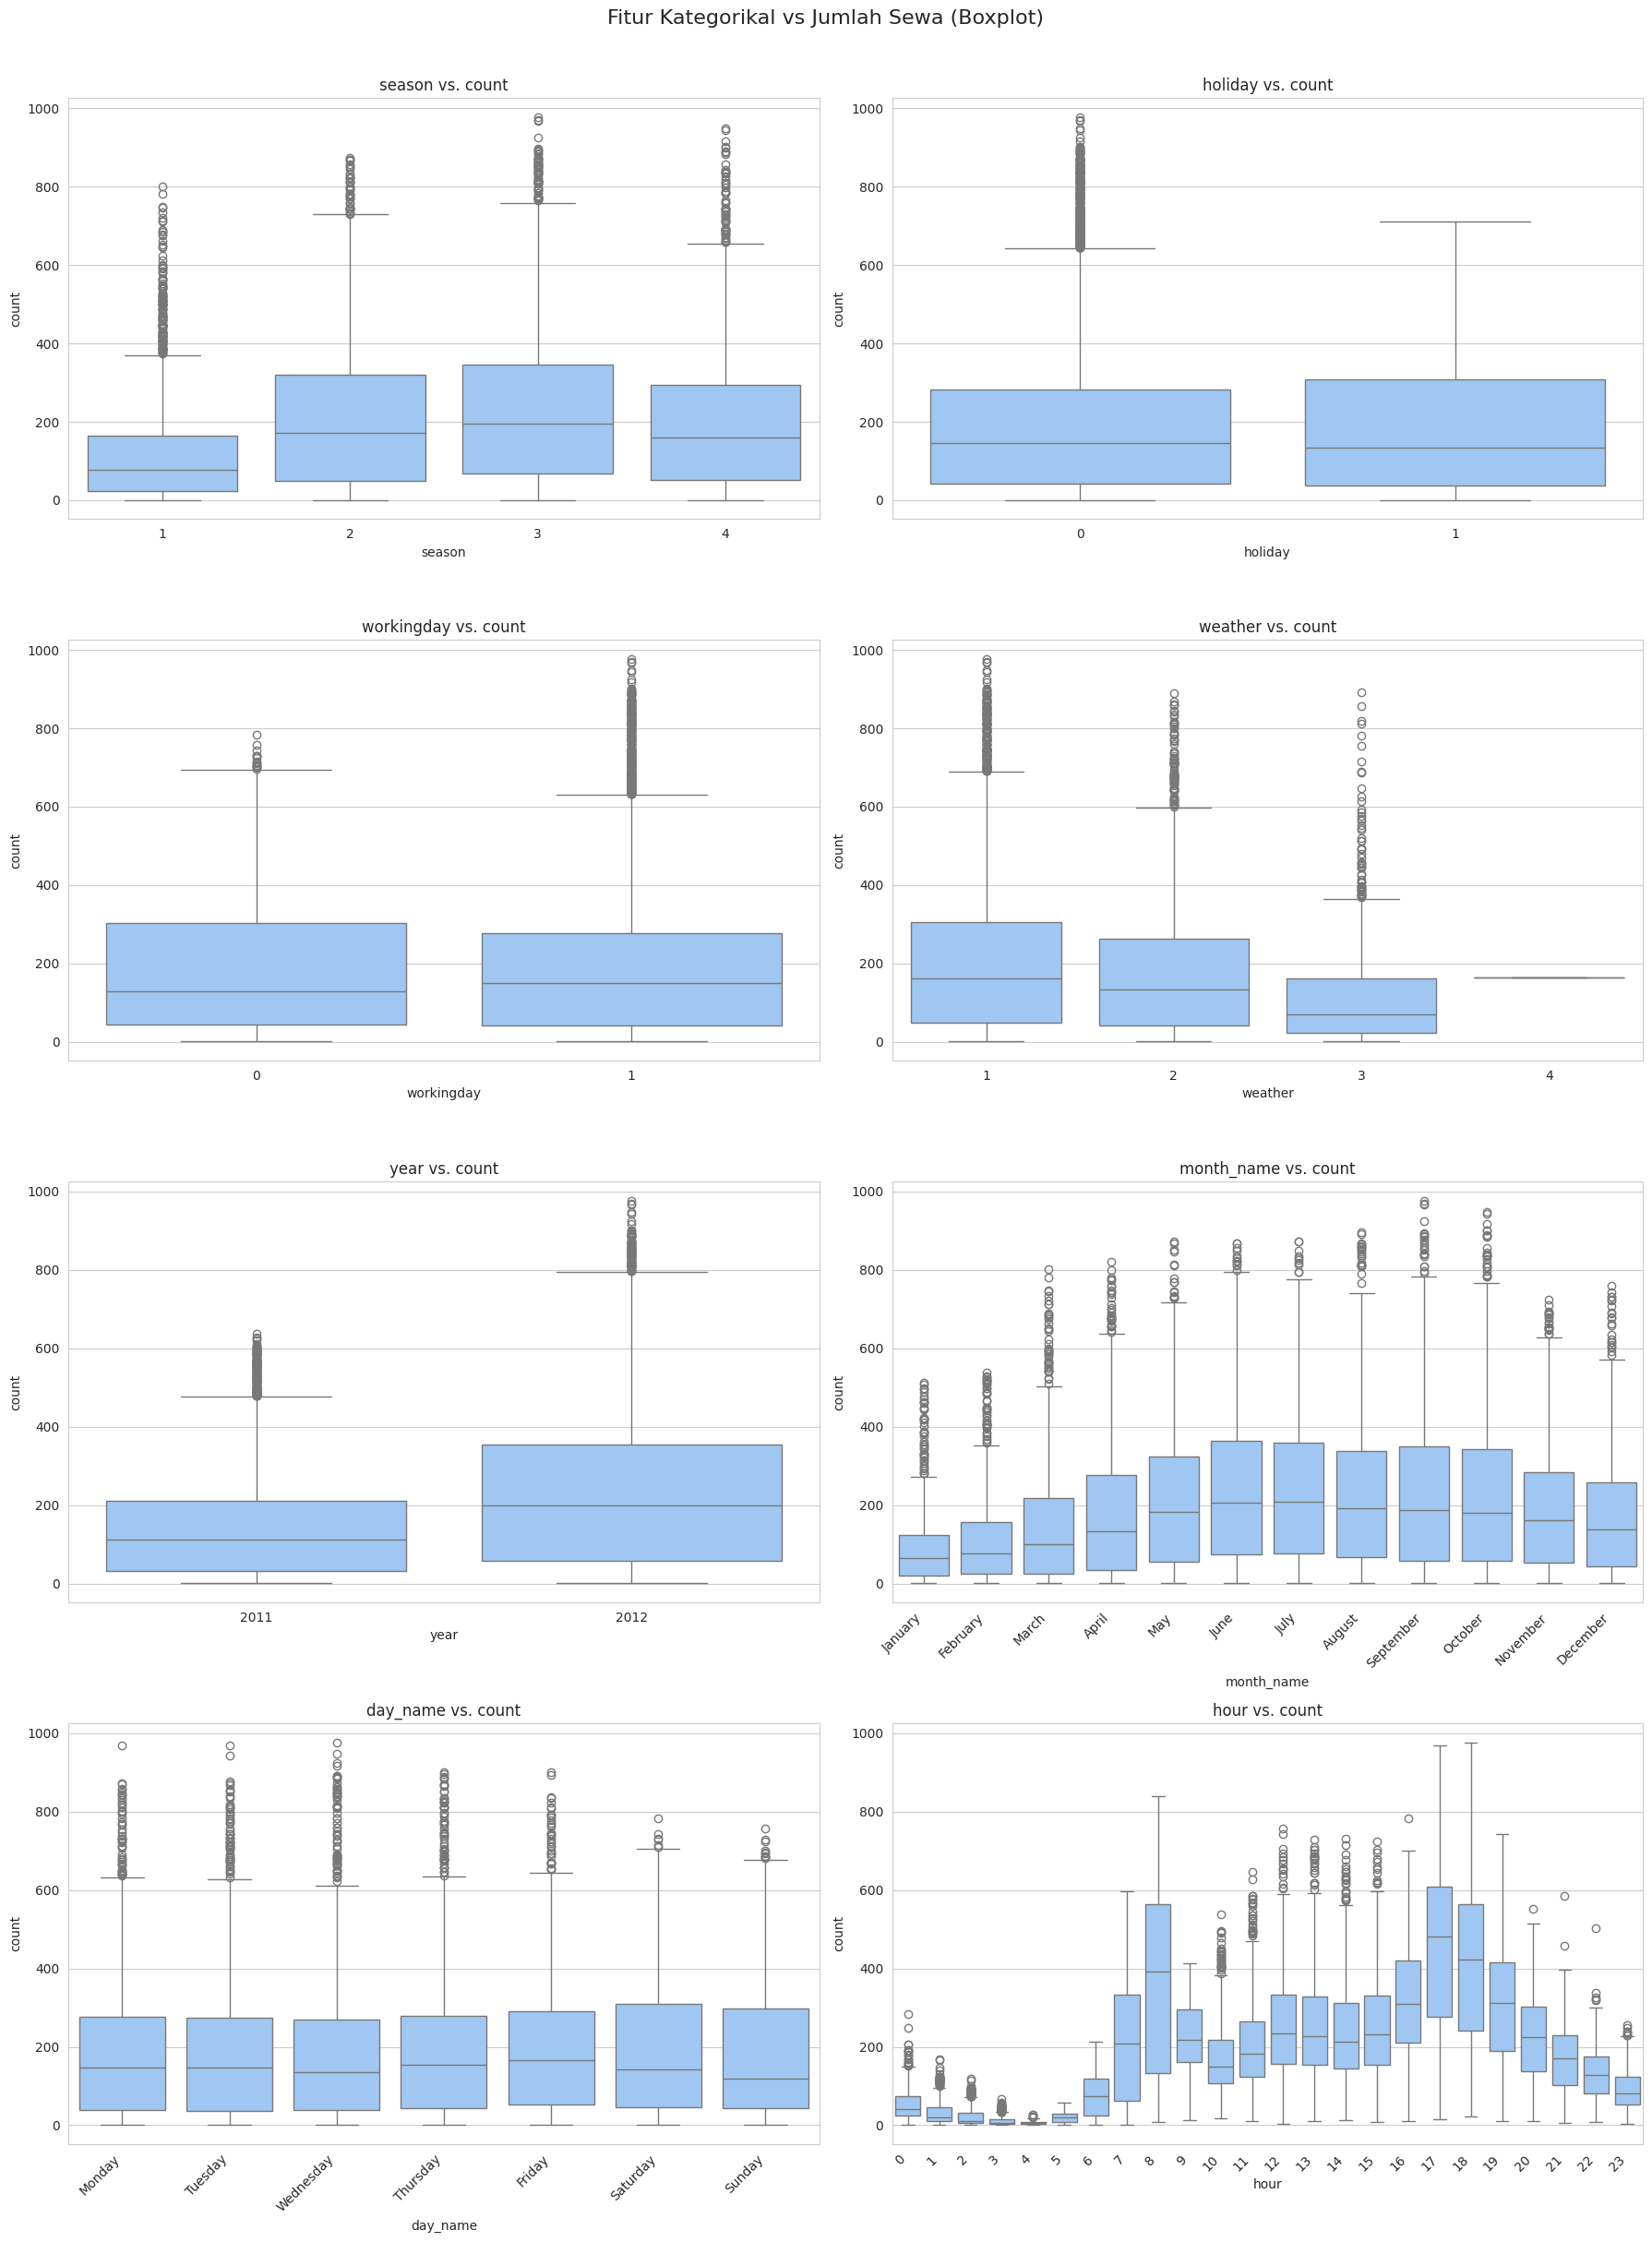

In [10]:
if 'df_eda' in locals():
    categorical_features_eda = ['season', 'holiday', 'workingday', 'weather',
                                'year', 'month_name', 'day_name', 'hour'] # dari sel 10

    plt.figure(figsize=(18, 24))
    for i, col in enumerate(categorical_features_eda):
        plt.subplot(4, 2, i + 1)
        order_list = None
        if col == 'day_name':
            order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        elif col == 'month_name':
            order_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        elif col == 'hour': # Urutkan jam
            order_list = sorted(df_eda[col].unique())

        sns.boxplot(x=col, y='count', data=df_eda, order=order_list)
        plt.title(f'{col} vs. count')
        if df_eda[col].nunique() > 5 or col in ['month_name','day_name']:
            plt.xticks(rotation=45, ha='right')
    plt.suptitle("Fitur Kategorikal vs Jumlah Sewa (Boxplot)", y=1.01, fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("df_eda belum dibuat.")

Wawasan dari Sel 11 (Kategorikal):

season: Musim panas (3) dan musim gugur (4) menunjukkan median count yang lebih tinggi dibandingkan musim dingin (1) dan musim semi (2).
holiday: Hari libur (1) memiliki variabilitas count yang lebih besar dan median yang sedikit lebih rendah dibandingkan hari non-libur (0), meskipun ada juga hari libur dengan permintaan tinggi.
workingday: Hari non-kerja (0, akhir pekan/libur) menunjukkan median count yang sedikit lebih tinggi dan sebaran yang lebih lebar dibandingkan hari kerja (1). Ini menandakan pola penggunaan yang berbeda.
weather: Cuaca cerah (1) jelas memiliki permintaan tertinggi. Semakin buruk cuaca (2, 3), permintaan menurun signifikan. Cuaca ekstrem (4) memiliki permintaan sangat rendah dan jarang terjadi.
year: Tahun 2012 menunjukkan permintaan yang secara signifikan lebih tinggi dibandingkan 2011, mengindikasikan pertumbuhan bisnis atau popularitas.
month_name: Pola musiman terlihat jelas, dengan permintaan lebih tinggi di bulan-bulan hangat (Mei-Oktober) dan lebih rendah di bulan-bulan dingin.
day_name: Akhir pekan (Sabtu, Minggu) cenderung memiliki median permintaan yang lebih tinggi dan variabilitas yang lebih besar.
hour: Pola permintaan per jam sangat jelas, dengan puncak pada pagi hari (sekitar jam 8) dan sore/awal malam hari (sekitar jam 17-18), kemungkinan besar terkait dengan jam komuter.

3.7. Analisis Tren Waktu

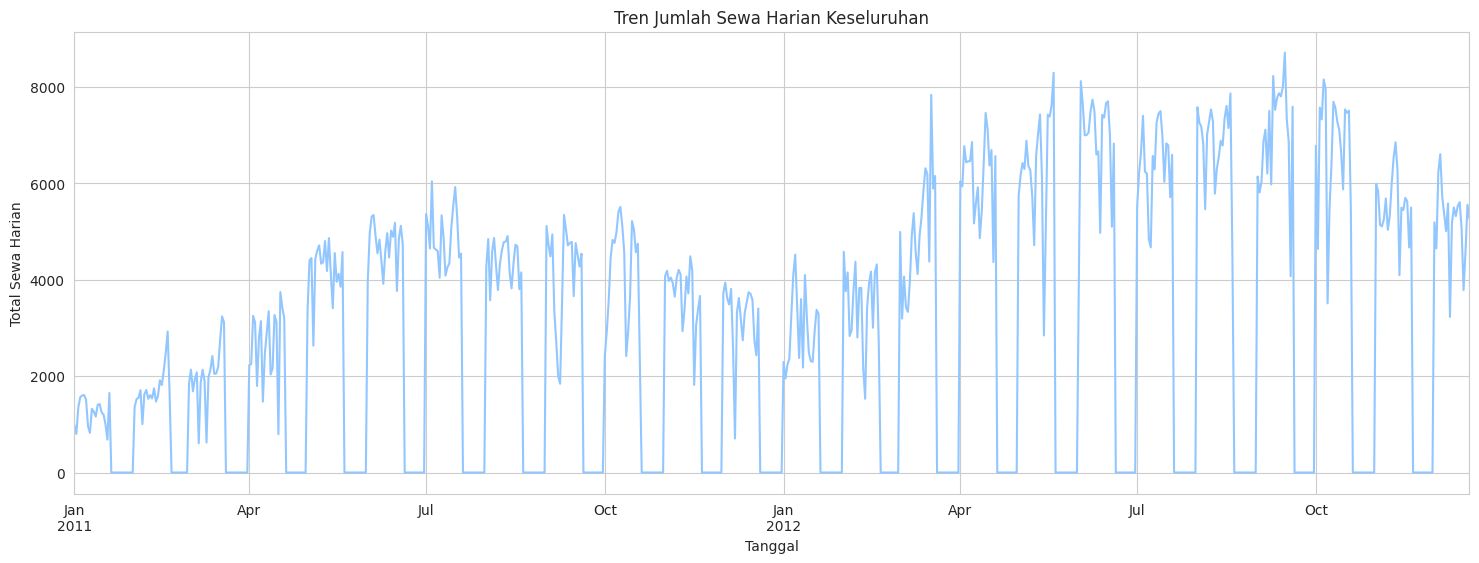

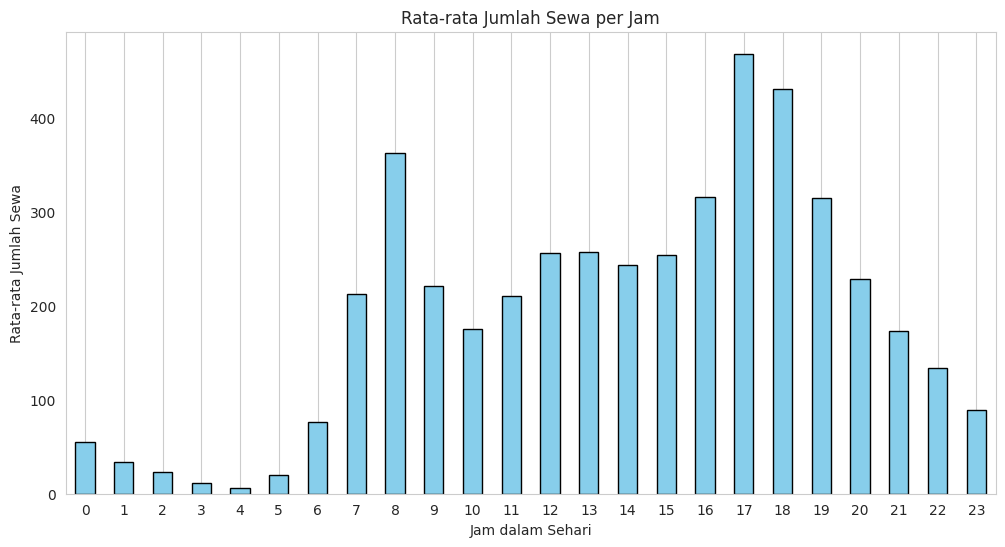

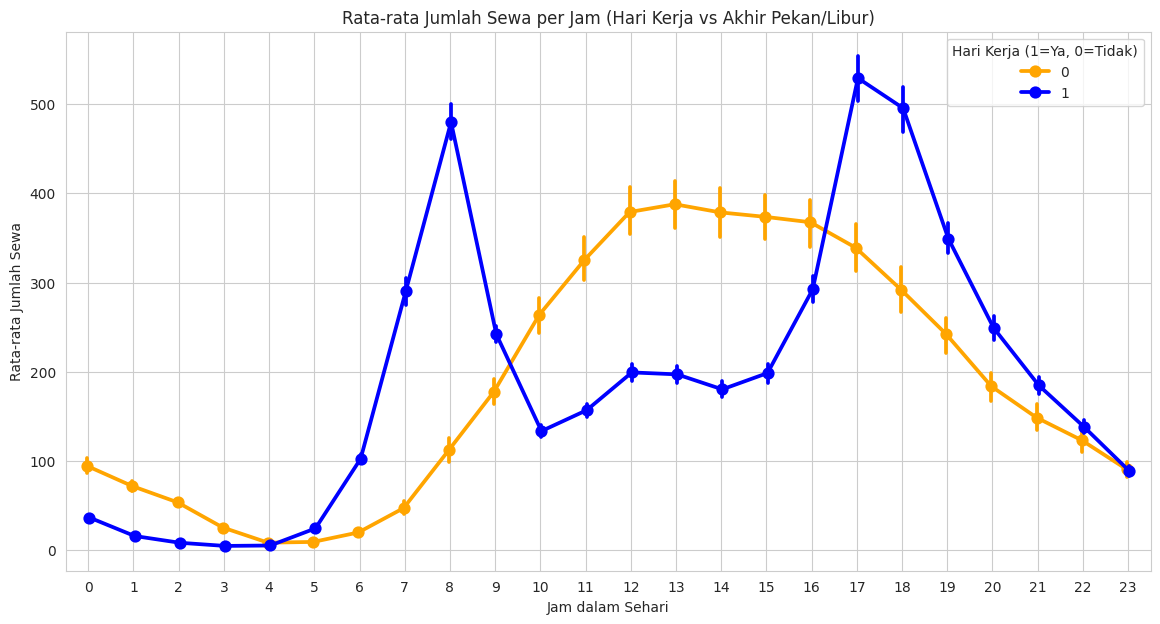

In [11]:
if 'df_eda' in locals():
    # Tren harian
    daily_counts = df_eda.set_index('datetime').resample('D')['count'].sum()
    plt.figure(figsize=(18, 6))
    daily_counts.plot()
    plt.title('Tren Jumlah Sewa Harian Keseluruhan')
    plt.xlabel('Tanggal')
    plt.ylabel('Total Sewa Harian')
    plt.grid(True)
    plt.show()

    # Rata-rata sewa per jam
    plt.figure(figsize=(12, 6))
    hourly_avg_counts = df_eda.groupby('hour')['count'].mean()
    hourly_avg_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Rata-rata Jumlah Sewa per Jam')
    plt.xlabel('Jam dalam Sehari')
    plt.ylabel('Rata-rata Jumlah Sewa')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

    # Rata-rata sewa per jam pada hari kerja vs akhir pekan/libur
    plt.figure(figsize=(14, 7))
    sns.pointplot(data=df_eda, x='hour', y='count', hue='workingday', palette={0: 'orange', 1: 'blue'}, dodge=True)
    plt.title('Rata-rata Jumlah Sewa per Jam (Hari Kerja vs Akhir Pekan/Libur)')
    plt.xlabel('Jam dalam Sehari')
    plt.ylabel('Rata-rata Jumlah Sewa')
    plt.legend(title='Hari Kerja (1=Ya, 0=Tidak)')
    plt.grid(True)
    plt.show()
else:
    print("df_eda belum dibuat.")

Wawasan dari Sel 12:

Plot tren harian menunjukkan adanya pertumbuhan permintaan sewa sepeda secara keseluruhan dari awal 2011 hingga akhir 2012. Juga terlihat adanya pola musiman yang berulang setiap tahun.
Rata-rata sewa per jam menunjukkan dua puncak utama: satu di pagi hari (sekitar jam 7-9 pagi) dan satu lagi yang lebih tinggi di sore/malam hari (sekitar jam 5-7 malam). Permintaan sangat rendah pada jam-jam larut malam/dini hari.
Ketika dibedakan berdasarkan workingday:
Pada hari kerja (1), puncak pagi dan sore sangat jelas, sesuai dengan jam pergi dan pulang kerja.
Pada akhir pekan/libur (0), pola permintaan lebih landai dan menyebar sepanjang siang hingga sore hari, tanpa puncak tajam seperti pada hari kerja. Permintaan tertinggi terjadi di sekitar tengah hari hingga sore.


## 3.8. Kesimpulan EDA dan Langkah Selanjutnya

**Wawasan Utama dari EDA:**
* Variabel target `count` sangat miring dan transformasi logaritmik (`np.log1p`) efektif untuk menormalkannya. Ini akan digunakan sebagai target dalam pemodelan.
* Fitur `atemp` sangat berkorelasi dengan `temp` dan akan dihapus.
* Fitur `windspeed` dan `humidity` memiliki beberapa nilai yang berpotensi menjadi pencilan atau data tidak tercatat (misalnya, `windspeed=0`, `humidity=0`). Winsorizing akan diterapkan untuk menangani ini.
* Fitur waktu (tahun, bulan, hari dalam seminggu, jam) menunjukkan pola yang kuat dan akan direkayasa menjadi fitur numerik (misalnya, ekstraksi langsung dan fitur siklikal) dan kategorikal (untuk OHE).
* Fitur `weather` dan `season` memiliki pengaruh signifikan terhadap permintaan.
* Ada tren pertumbuhan permintaan dari tahun 2011 ke 2012.
* Pola permintaan per jam sangat berbeda antara hari kerja dan akhir pekan/libur.

**Langkah Selanjutnya:**
1.  **Pra-pemrosesan Data Formal**: Menerapkan fungsi rekayasa fitur dan winsorizing pada set data latih dan validasi.
2.  **Pembuatan Pipeline Scikit-learn**: Menggabungkan semua langkah pra-pemrosesan (scaling, one-hot encoding) dan model dalam satu pipeline.
3.  **Perbandingan Model Dasar**: Mengevaluasi beberapa model regresi standar dengan parameter default menggunakan validasi silang.
4.  **Tuning Hyperparameter**: Memilih model terbaik dan melakukan tuning hyperparameter.
5.  **Evaluasi Model Final**: Mengevaluasi model terbaik dengan parameter optimal pada set validasi.
6.  **Penyimpanan Model**: Menyimpan pipeline model final menggunakan `pickle`.

## 4. Pra-pemrosesan Data dan Rekayasa Fitur

Pada tahap ini, kita akan secara formal menerapkan fungsi-fungsi pra-pemrosesan yang telah didefinisikan untuk:
- Ekstraksi fitur dari kolom `datetime`.
- Membuat fitur siklikal untuk komponen waktu.
- Melakukan winsorizing pada fitur `humidity` dan `windspeed`.
- Menghapus kolom `atemp` dan kolom asli `datetime` setelah ekstraksi.
- Memastikan data siap untuk dimasukkan ke dalam pipeline Scikit-learn.

Target variabel `count` juga akan di-log-transformasi untuk menormalkan distribusinya.

Definisi Fungsi Pra-pemrosesan

In [12]:
# Fungsi kustom untuk winsorizing (pastikan scipy sudah terinstal)
from scipy.stats.mstats import winsorize

def winsorize_series_robust(df_or_series, column_name=None, limits=(0.01, 0.01)):
    if isinstance(df_or_series, pd.DataFrame):
        if column_name is None or column_name not in df_or_series.columns:
            raise ValueError("Jika input adalah DataFrame, column_name harus valid.")
        series_to_winsorize = df_or_series[column_name].copy()
    else: # Asumsi Series
        series_to_winsorize = df_or_series.copy()

    winsorized_array = winsorize(series_to_winsorize, limits=limits)

    if isinstance(df_or_series, pd.DataFrame):
        df_out = df_or_series.copy()
        df_out[column_name] = winsorized_array
        return df_out
    else:
        return pd.Series(winsorized_array, name=df_or_series.name, index=df_or_series.index)

# Fungsi untuk pra-pemrosesan awal (menghapus 'casual' dan 'registered' dari X)
def preprocess_initial_features(input_df):
    df = input_df.copy()
    if 'datetime' in df.columns:
        df['hour_val'] = df['datetime'].dt.hour
        df['month_val'] = df['datetime'].dt.month
        df['weekday_val'] = df['datetime'].dt.weekday # Senin=0, Minggu=6
        df['day'] = df['datetime'].dt.day
        df['year_cat'] = df['datetime'].dt.year.astype(str) # Tahun sebagai kategori
        df['dayofyear'] = df['datetime'].dt.dayofyear
        df = df.drop('datetime', axis=1, errors='ignore')
    if 'atemp' in df.columns:
        df = df.drop('atemp', axis=1, errors='ignore')
    # Hapus kolom 'casual' dan 'registered' jika ada di X (seharusnya sudah di-drop saat membuat X)
    df = df.drop(columns=['casual', 'registered'], axis=1, errors='ignore')
    return df

# Fungsi untuk membuat fitur siklikal
def create_cyclical_features(input_df):
    df = input_df.copy()
    if 'hour_val' in df.columns:
        df['hour_sin'] = np.sin(2 * np.pi * df['hour_val']/24.0)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour_val']/24.0)
    if 'month_val' in df.columns:
        df['month_sin'] = np.sin(2 * np.pi * df['month_val']/12.0)
        df['month_cos'] = np.cos(2 * np.pi * df['month_val']/12.0)
    if 'weekday_val' in df.columns:
        df['weekday_sin'] = np.sin(2 * np.pi * df['weekday_val']/7.0)
        df['weekday_cos'] = np.cos(2 * np.pi * df['weekday_val']/7.0)
    # Kolom _val akan digunakan untuk OHE, jadi jangan di-drop di sini
    return df

# FunctionTransformer untuk winsorizing (akan diterapkan secara terpisah sebelum ColumnTransformer)
winsorizer_humidity_ft = FunctionTransformer(winsorize_series_robust, kw_args={'column_name':'humidity', 'limits': (0.01, 0.01)})
winsorizer_windspeed_ft = FunctionTransformer(winsorize_series_robust, kw_args={'column_name':'windspeed', 'limits': (0.05, 0.05)})

print("Fungsi-fungsi pra-pemrosesan siap.")

Fungsi-fungsi pra-pemrosesan siap.


Pemisahan Data dan Penerapan Pra-pemrosesan

In [13]:
if df_train_raw is not None:
    # Pisahkan fitur (X) dan target (y) dari df_train_raw
    X = df_train_raw.drop(['casual', 'registered', 'count'], axis=1)
    y_original = df_train_raw['count'] # Simpan target asli untuk evaluasi akhir
    y = np.log1p(y_original) # Log-transformasi target

    # Bagi data menjadi set latih dan set validasi (80:20)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Simpan y_val dalam skala asli juga untuk evaluasi MAPE/RMSLE nanti
    # Kita bisa mendapatkannya dengan melakukan inverse transform pada y_val (yang sudah di-log)
    y_val_original = np.expm1(y_val)


    print("Data berhasil dipisahkan menjadi set latih dan validasi.")
    print(f"Bentuk X_train (mentah): {X_train.shape}, y_train (log-transformed): {y_train.shape}")
    print(f"Bentuk X_val (mentah): {X_val.shape}, y_val (log-transformed): {y_val.shape}")

    # 1. Terapkan pra-pemrosesan awal (ekstraksi datetime, drop atemp)
    print("\nMenerapkan preprocess_initial_features...")
    X_train_p1 = preprocess_initial_features(X_train.copy())
    X_val_p1 = preprocess_initial_features(X_val.copy())

    # 2. Terapkan pembuatan fitur siklikal
    print("\nMenerapkan create_cyclical_features...")
    X_train_p2 = create_cyclical_features(X_train_p1)
    X_val_p2 = create_cyclical_features(X_val_p1)

    # 3. Terapkan Winsorizing (sebagai langkah terpisah sebelum ColumnTransformer)
    print("\nMenerapkan winsorizing...")
    if 'humidity' in X_train_p2.columns:
        X_train_engineered = winsorizer_humidity_ft.fit_transform(X_train_p2)
        X_val_engineered = winsorizer_humidity_ft.transform(X_val_p2) # Gunakan transform untuk data validasi
    else:
        X_train_engineered = X_train_p2.copy() # Jika kolom tidak ada
        X_val_engineered = X_val_p2.copy()

    if 'windspeed' in X_train_engineered.columns: # Pastikan winsorizing berikutnya dilakukan pada output sebelumnya
        X_train_engineered = winsorizer_windspeed_ft.fit_transform(X_train_engineered)
        X_val_engineered = winsorizer_windspeed_ft.transform(X_val_engineered)

    print(f"\nBentuk X_train setelah semua rekayasa fitur: {X_train_engineered.shape}")
    print(f"Kolom X_train_engineered: {X_train_engineered.columns.tolist()}")
    print("\nContoh X_train_engineered:")
    display(X_train_engineered.head())

    # Lakukan hal yang sama untuk data uji (X_test_final) jika ada
    if df_test_raw is not None:
        X_test_final = df_test_raw.copy() # X_test_final tidak punya kolom 'count', 'casual', 'registered'
        X_test_final_p1 = preprocess_initial_features(X_test_final)
        X_test_final_p2 = create_cyclical_features(X_test_final_p1)

        X_test_final_engineered = X_test_final_p2.copy() # Inisialisasi
        if 'humidity' in X_test_final_engineered.columns:
            X_test_final_engineered = winsorizer_humidity_ft.transform(X_test_final_engineered) # Hanya transform

        if 'windspeed' in X_test_final_engineered.columns:
            X_test_final_engineered = winsorizer_windspeed_ft.transform(X_test_final_engineered) # Hanya transform

        print(f"\nBentuk X_test_final setelah semua rekayasa fitur: {X_test_final_engineered.shape}")
else:
    print("df_train_raw belum dimuat.")

Data berhasil dipisahkan menjadi set latih dan validasi.
Bentuk X_train (mentah): (8708, 9), y_train (log-transformed): (8708,)
Bentuk X_val (mentah): (2178, 9), y_val (log-transformed): (2178,)

Menerapkan preprocess_initial_features...

Menerapkan create_cyclical_features...

Menerapkan winsorizing...

Bentuk X_train setelah semua rekayasa fitur: (8708, 19)
Kolom X_train_engineered: ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed', 'hour_val', 'month_val', 'weekday_val', 'day', 'year_cat', 'dayofyear', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']

Contoh X_train_engineered:


,season,holiday,workingday,weather,temp,humidity,windspeed,hour_val,month_val,weekday_val,day,year_cat,dayofyear,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos
2815,3,0,1,1,27.88,83,6.0032,5,7,2,6,2011,187,0.965926,0.258819,-0.500000,-0.866025,0.974928,-0.222521
8695,3,0,0,1,36.90,39,19.9995,16,8,5,4,2012,217,-0.866025,-0.500000,-0.866025,-0.500000,-0.974928,-0.222521
8406,3,0,1,1,32.80,41,16.9979,15,7,2,11,2012,193,-0.707107,-0.707107,-0.500000,-0.866025,0.974928,-0.222521
1543,2,0,0,2,14.76,93,7.0015,4,4,6,10,2011,100,0.866025,0.500000,0.866025,-0.500000,-0.781831,0.623490
4952,4,0,0,1,13.12,45,16.9979,10,11,5,19,2011,323,0.500000,-0.866025,-0.500000,0.866025,-0.974928,-0.222521



Bentuk X_test_final setelah semua rekayasa fitur: (6493, 19)


Wawasan Sel 16:

Data X (fitur) dan y (target) dipisahkan dari df_train_raw. Target y langsung di-log-transformasi.
X_train, X_val, y_train, y_val dibuat. y_val_original disimpan untuk evaluasi akhir.
Fungsi preprocess_initial_features dan create_cyclical_features diterapkan secara berurutan.
Winsorizing diterapkan sebagai langkah terpisah pada X_train_engineered dan X_val_engineered (menggunakan fit_transform pada train dan transform pada val).
Langkah yang sama diterapkan pada X_test_final (jika ada), tetapi hanya menggunakan .transform() dari transformer yang sudah di-fit pada data latih.

## 5. Pembuatan Pipeline dengan Scikit-learn

Sekarang kita akan mendefinisikan kolom-kolom yang akan di-scale dan di-one-hot-encode, lalu membuat `ColumnTransformer` untuk menerapkan transformasi ini. Setelah itu, kita akan menggabungkannya dengan model XGBoost ke dalam sebuah `Pipeline` Scikit-learn.

Definisi Kolom dan Pembuatan Pipeline

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Pastikan Pipeline diimpor di sini atau di sel impor utama
import xgboost as xgb # Pastikan xgboost diimpor jika belum

if 'X_train_engineered' in locals() and X_train_engineered is not None:
    # Definisikan kolom untuk setiap jenis transformer
    # Fitur numerik yang akan di-scale (termasuk yang sudah di-winsorize)
    numeric_features_for_scaling = [
        'temp',
        'humidity', # Sudah di-winsorize, sekarang akan di-scale
        'windspeed', # Sudah di-winsorize, sekarang akan di-scale
        'day',
        'dayofyear',
        'hour_sin',
        'hour_cos',
        'month_sin',
        'month_cos',
        'weekday_sin',
        'weekday_cos'
    ]
    # Saring hanya kolom yang benar-benar ada di X_train_engineered
    numeric_features_for_scaling = [col for col in numeric_features_for_scaling if col in X_train_engineered.columns]

    # Fitur kategorikal yang akan di-one-hot-encode
    # Kolom '_val' (hour_val, month_val, weekday_val) dan 'year_cat' digunakan untuk OHE
    categorical_features_for_ohe = [
        'season',
        'holiday',
        'workingday',
        'weather',
        'hour_val',
        'month_val',
        'weekday_val',
        'year_cat'
    ]
    categorical_features_for_ohe = [col for col in categorical_features_for_ohe if col in X_train_engineered.columns]

    print("Fitur Numerik untuk Scaling:", numeric_features_for_scaling)
    print("Fitur Kategorikal untuk OHE:", categorical_features_for_ohe)

    transformers_ct_list = []
    if numeric_features_for_scaling:
        transformers_ct_list.append(
            ('num_scale', StandardScaler(), numeric_features_for_scaling)
        )
    if categorical_features_for_ohe:
        transformers_ct_list.append(
            ('cat_ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features_for_ohe)
        )

    # Buat ColumnTransformer
    if not transformers_ct_list:
        # Jika tidak ada fitur yang perlu di-transform, pipeline hanya akan berisi model
        preprocessor_ct = 'passthrough'
        print("\nTidak ada transformer yang dibuat dalam ColumnTransformer (passthrough).")
    else:
        preprocessor_ct = ColumnTransformer(
            transformers=transformers_ct_list,
            remainder='drop' # Kolom yang tidak disebutkan akan dihapus.
                             # Ganti ke 'passthrough' jika ingin menyertakannya tanpa transformasi.
        )
        print("\nColumnTransformer (preprocessor_ct) berhasil dibuat.")
        print(preprocessor_ct)

    # Definisikan model XGBoost (parameter awal, akan di-tuning nanti atau menggunakan nilai terbaik)
    xgboost_regressor_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

    # Buat pipeline akhir Scikit-learn
    # Karena y sudah di-log-transform, kita tidak perlu TransformedTargetRegressor di sini.
    # Model akan dilatih pada y_log dan memprediksi y_log.
    # Transformasi balik (np.expm1) akan dilakukan setelah prediksi.
    final_sklearn_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_ct),
        ('xgbregressor', xgboost_regressor_base)
    ])

    print("\nPipeline Scikit-learn lengkap berhasil dibuat:")
    print(final_sklearn_pipeline)
else:
    print("Variabel X_train_engineered belum terdefinisi. Jalankan sel pra-pemrosesan sebelumnya.")

Fitur Numerik untuk Scaling: ['temp', 'humidity', 'windspeed', 'day', 'dayofyear', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']
Fitur Kategorikal untuk OHE: ['season', 'holiday', 'workingday', 'weather', 'hour_val', 'month_val', 'weekday_val', 'year_cat']

ColumnTransformer (preprocessor_ct) berhasil dibuat.
ColumnTransformer(transformers=[('num_scale', StandardScaler(),
                                 ['temp', 'humidity', 'windspeed', 'day',
                                  'dayofyear', 'hour_sin', 'hour_cos',
                                  'month_sin', 'month_cos', 'weekday_sin',
                                  'weekday_cos']),
                                ('cat_ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['season', 'holiday', 'workingday', 'weat

Penjelasan Sel 18:

Definisi Fitur:
numeric_features_for_scaling: Daftar fitur numerik yang akan di-scale menggunakan StandardScaler. Ini termasuk temp, fitur waktu yang diekstrak dan disiklikalkan, serta humidity dan windspeed (yang sudah di-winsorize di langkah sebelumnya).
categorical_features_for_ohe: Daftar fitur kategorikal yang akan di-one-hot-encode. Kita menggunakan kolom _val (seperti hour_val) untuk OHE agar mendapatkan representasi jam, bulan, dan hari sebagai kategori diskrit, bersama dengan fitur kategorikal asli dan year_cat.
ColumnTransformer:
StandardScaler diterapkan pada numeric_features_for_scaling.
OneHotEncoder diterapkan pada categorical_features_for_ohe. handle_unknown='ignore' akan mengabaikan kategori baru yang mungkin muncul di data uji (meskipun idealnya tidak ada jika pra-pemrosesan konsisten), dan drop='first' digunakan untuk menghindari multikolinearitas. sparse_output=False menghasilkan array NumPy padat.
remainder='drop': Kolom apa pun yang tidak disebutkan dalam numeric_features_for_scaling atau categorical_features_for_ohe akan dihapus. Jika ada fitur lain yang ingin Anda sertakan apa adanya (tanpa transformasi), Anda bisa menggantinya menjadi remainder='passthrough'.
XGBoost Regressor: Sebuah instance dasar dari xgb.XGBRegressor dibuat. Parameter untuk model ini akan kita optimalkan nanti menggunakan GridSearchCV atau Anda bisa langsung memasukkan parameter terbaik yang sudah Anda ketahui.
Pipeline Akhir: sklearn.pipeline.Pipeline menggabungkan preprocessor_ct (yang melakukan scaling dan OHE) dengan xgbregressor_base.
Transformasi Target: Kita telah melakukan log-transformasi pada y_train dan y_val secara manual (np.log1p). Oleh karena itu, pipeline ini akan dilatih untuk memprediksi nilai log. Transformasi balik (np.expm1) akan kita lakukan setelah mendapatkan prediksi dari pipeline ini.
Setelah sel ini berhasil dijalankan, final_sklearn_pipeline akan berisi objek pipeline Scikit-learn yang siap untuk dilatih.

## 6. Perbandingan Model Dasar (Manual)

Sebelum melakukan tuning hyperparameter yang mendalam, kita akan melatih beberapa model dasar dengan parameter default menggunakan validasi silang untuk mendapatkan gambaran performa relatif mereka. Pipeline pra-pemrosesan (`preprocessor_ct`) yang telah dibuat akan diterapkan pada setiap model untuk konsistensi.

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
import xgboost as xgb # Pastikan xgboost sudah diimpor
from sklearn.model_selection import cross_val_score, KFold
# Pipeline sudah diimpor di sel sebelumnya (jika belum, from sklearn.pipeline import Pipeline)
# Numpy dan Pandas sudah diimpor di sel-sel awal

if 'X_train_engineered' in locals() and 'y_train' in locals() and 'preprocessor_ct' in locals():
    models_to_compare = {
        "Linear Regression": LinearRegression(),
        "Ridge": Ridge(random_state=42),
        "Lasso": Lasso(random_state=42),
        "ElasticNet": ElasticNet(random_state=42),
        "KNeighbors Regressor": KNeighborsRegressor(n_jobs=-1), # n_jobs=-1 untuk menggunakan semua prosesor
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
        "Random Forest Regressor": RandomForestRegressor(random_state=42, n_jobs=-1),
        "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
        "Extra Trees Regressor": ExtraTreesRegressor(random_state=42, n_jobs=-1),
        # "SVR": SVR(), # SVR bisa sangat lama dilatih, opsional untuk disertakan
        "XGBoost Regressor (Default)": xgb.XGBRegressor(random_state=42, n_jobs=-1)
    }

    results = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross-validation

    print("Memulai perbandingan model dasar dengan validasi silang (mungkin memakan waktu)...")

    for model_name, model_obj in models_to_compare.items():
        print(f"Mengevaluasi: {model_name}...")

        # Buat pipeline lengkap dengan preprocessor dan model saat ini
        # Kita menamai langkah model sebagai 'regressor' agar konsisten dengan contoh tuning nanti
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor_ct),
            ('regressor', model_obj)
        ])

        # Evaluasi menggunakan cross-validation
        try:
            # R2 score (semakin tinggi semakin baik)
            cv_r2 = cross_val_score(pipeline, X_train_engineered, y_train, cv=kf, scoring='r2', n_jobs=-1)

            # Negative Mean Squared Error (semakin dekat ke 0 semakin baik, karena ini negatif)
            cv_neg_mse = cross_val_score(pipeline, X_train_engineered, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
            cv_rmse = np.sqrt(-cv_neg_mse) # Ambil akar dari MSE positif untuk RMSE

            results.append({
                "Model": model_name,
                "Mean R2 (log)": np.mean(cv_r2),
                "Std R2 (log)": np.std(cv_r2),
                "Mean RMSE (log)": np.mean(cv_rmse),
                "Std RMSE (log)": np.std(cv_rmse)
            })
            print(f"Selesai: {model_name} | Mean R2 (log): {np.mean(cv_r2):.4f}, Mean RMSE (log): {np.mean(cv_rmse):.4f}")
        except Exception as e:
            print(f"Gagal mengevaluasi {model_name}: {e}")
            results.append({
                "Model": model_name,
                "Mean R2 (log)": np.nan,
                "Std R2 (log)": np.nan,
                "Mean RMSE (log)": np.nan,
                "Std RMSE (log)": np.nan
            })

    results_df = pd.DataFrame(results).sort_values(by="Mean R2 (log)", ascending=False)

    print("\n--- Hasil Perbandingan Model Dasar (Berdasarkan Validasi Silang pada Data Latih) ---")
    display(results_df)
else:
    print("Pastikan X_train_engineered, y_train, dan preprocessor_ct sudah terdefinisi dari sel sebelumnya.")

Memulai perbandingan model dasar dengan validasi silang (mungkin memakan waktu)...
Mengevaluasi: Linear Regression...
Selesai: Linear Regression | Mean R2 (log): 0.8315, Mean RMSE (log): 0.5797
Mengevaluasi: Ridge...
Selesai: Ridge | Mean R2 (log): 0.8304, Mean RMSE (log): 0.5816
Mengevaluasi: Lasso...
Selesai: Lasso | Mean R2 (log): -0.0018, Mean RMSE (log): 1.4155
Mengevaluasi: ElasticNet...
Selesai: ElasticNet | Mean R2 (log): 0.1890, Mean RMSE (log): 1.2737
Mengevaluasi: KNeighbors Regressor...
Selesai: KNeighbors Regressor | Mean R2 (log): 0.8076, Mean RMSE (log): 0.6196
Mengevaluasi: Decision Tree Regressor...
Selesai: Decision Tree Regressor | Mean R2 (log): 0.9013, Mean RMSE (log): 0.4438
Mengevaluasi: Random Forest Regressor...
Selesai: Random Forest Regressor | Mean R2 (log): 0.9514, Mean RMSE (log): 0.3117
Mengevaluasi: Gradient Boosting Regressor...
Selesai: Gradient Boosting Regressor | Mean R2 (log): 0.9259, Mean RMSE (log): 0.3848
Mengevaluasi: Extra Trees Regressor...
S

,Model,Mean R2 (log),Std R2 (log),Mean RMSE (log),Std RMSE (log)
9,XGBoost Regressor (Default),0.958911,0.002058,0.286590,0.010978
8,Extra Trees Regressor,0.952958,0.001939,0.306655,0.010137
6,Random Forest Regressor,0.951368,0.002593,0.311658,0.008701
7,Gradient Boosting Regressor,0.925942,0.002080,0.384802,0.011045
5,Decision Tree Regressor,0.901253,0.006870,0.443847,0.010889
0,Linear Regression,0.831529,0.010805,0.579696,0.006075
1,Ridge,0.830421,0.010691,0.581613,0.005598
4,KNeighbors Regressor,0.807639,0.010479,0.619607,0.004975
3,ElasticNet,0.188976,0.005054,1.273712,0.038461
2,Lasso,-0.001764,0.002048,1.415452,0.037585


## Interpretasi Hasil Perbandingan Model dan Pemilihan Model untuk Tuning

Tabel `results_df` di atas menunjukkan performa rata-rata (dan standar deviasi) dari berbagai model dasar menggunakan validasi silang 5-fold pada data latih (`X_train_engineered` dan `y_train`). Metrik yang ditampilkan (`R2` dan `RMSE`) adalah pada **skala logaritmik** dari variabel target `count` (karena `y_train` kita adalah `np.log1p(count)`).

**Hal yang perlu diperhatikan saat menganalisis tabel:**
- **Mean R2 (log)**: Skor R-squared menunjukkan proporsi varians dalam variabel dependen yang dapat diprediksi dari variabel independen. Nilai yang lebih tinggi (mendekati 1) umumnya lebih baik, menandakan model lebih cocok dengan data (pada skala log).
- **Mean RMSE (log)**: Root Mean Squared Error adalah standar deviasi dari residual (error prediksi). Nilai yang lebih rendah menunjukkan error prediksi rata-rata yang lebih kecil pada skala log, yang berarti prediksi model lebih dekat dengan nilai aktual.
- **Std R2 (log) dan Std RMSE (log)**: Standar deviasi dari skor metrik di seluruh fold validasi silang. Nilai standar deviasi yang lebih rendah menunjukkan bahwa performa model lebih konsisten dan stabil di berbagai subset data latih. Model dengan standar deviasi tinggi mungkin berkinerja baik pada beberapa fold tetapi buruk pada fold lainnya (indikasi overfitting pada subset tertentu).

**Pemilihan Model untuk Tuning:**
- Identifikasi model yang secara konsisten menunjukkan **R2 tinggi** dan **RMSE rendah**.
- Perhatikan juga **stabilitas performa** (standar deviasi rendah). Model yang sedikit lebih buruk performanya tetapi jauh lebih stabil mungkin lebih disukai daripada model dengan performa rata-rata tinggi tetapi sangat tidak stabil.
- Model berbasis *ensemble tree* seperti Random Forest, Gradient Boosting, Extra Trees, dan XGBoost seringkali memberikan performa yang baik pada dataset tabular seperti ini.
- Pertimbangkan juga **waktu komputasi** yang dibutuhkan oleh masing-masing model selama validasi silang, meskipun untuk tahap ini fokus utama adalah pada performa prediktif.

Berdasarkan hasil tabel `results_df` yang Anda dapatkan sebelumnya, **XGBoost Regressor (Default)** menunjukkan performa terbaik dengan Mean R2 (log) tertinggi (~0.959) dan Mean RMSE (log) terendah (~0.287). Oleh karena itu, kita akan memilih **XGBoost Regressor** untuk dilanjutkan ke tahap tuning hyperparameter.

## 7. Pemilihan dan Pelatihan Model Terbaik (XGBoost) dengan Pencarian Hyperparameter

Setelah memilih XGBoost Regressor sebagai model kandidat terbaik berdasarkan hasil perbandingan model dasar, langkah selanjutnya adalah melakukan tuning hyperparameter. Kita akan menggunakan `GridSearchCV` untuk mencari kombinasi hyperparameter yang optimal untuk XGBoost, dengan tujuan meningkatkan performanya lebih lanjut.

In [16]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline # Pastikan diimpor jika belum di sel sebelumnya
import xgboost as xgb # Pastikan xgboost sudah diimpor

if 'X_train_engineered' in locals() and 'y_train' in locals() and 'preprocessor_ct' in locals():

    print("Membuat pipeline spesifik untuk XGBoost untuk tuning...")

    # Definisikan model XGBoost (parameter awal untuk tuning)
    xgboost_for_tuning = xgb.XGBRegressor(random_state=42, n_jobs=-1,
                                          objective='reg:squarederror', # Umum untuk regresi
                                          # eval_metric='rmse' # Bisa diset jika ingin memantau metrik tertentu saat training XGBoost
                                         )

    # Buat pipeline dengan preprocessor dan model XGBoost untuk dituning
    # Nama langkah 'regressor' digunakan agar konsisten dengan param_grid
    pipeline_to_tune = Pipeline(steps=[
        ('preprocessor', preprocessor_ct),
        ('regressor', xgboost_for_tuning)
    ])

    # Definisikan grid parameter untuk GridSearchCV untuk XGBoost
    # Ini adalah contoh grid; Anda bisa memperluas atau mempersempitnya berdasarkan waktu komputasi dan hasil awal
    param_grid_xgb = {
        'regressor__n_estimators': [200, 300, 400], # Jumlah pohon
        'regressor__learning_rate': [0.05, 0.1],   # Laju pembelajaran
        'regressor__max_depth': [5, 7, 9],           # Kedalaman tree maksimum
        'regressor__min_child_weight': [1, 3],       # Bobot anak minimum (mengontrol overfitting)
        'regressor__subsample': [0.8, 1.0],          # Rasio sampel data latih yang digunakan untuk setiap pohon
        'regressor__colsample_bytree': [0.8, 1.0]    # Rasio fitur (kolom) yang digunakan untuk setiap pohon
        # Parameter lain yang bisa ditambahkan: 'gamma', 'reg_alpha', 'reg_lambda' untuk regularisasi
    }

    print("\nMencari hyperparameter terbaik untuk XGBoost dengan GridSearchCV (mungkin memakan waktu)...")
    # Menggunakan 3-fold CV untuk tuning agar lebih cepat, bisa dinaikkan (misal, 5) untuk hasil lebih robust
    cv_folds_tuning = KFold(n_splits=3, shuffle=True, random_state=42)

    # Kita akan tune berdasarkan R2 score (lebih tinggi lebih baik)
    # Anda juga bisa menggunakan 'neg_mean_squared_error' dan memaksimalkan nilai negatifnya (mendekati 0)
    grid_search_xgb = GridSearchCV(pipeline_to_tune, param_grid_xgb, cv=cv_folds_tuning,
                                   scoring='r2', n_jobs=-1, verbose=2) # verbose=2 untuk lebih banyak output

    # Latih GridSearchCV pada data latih yang sudah di-engineer dan y_train (log-transformed)
    grid_search_xgb.fit(X_train_engineered, y_train)

    print("\nPencarian hyperparameter selesai.")
    print(f"Parameter terbaik ditemukan untuk XGBoost: {grid_search_xgb.best_params_}")
    print(f"Skor R2 terbaik (log scale) dari GridSearchCV pada data latih (CV): {grid_search_xgb.best_score_:.4f}")

    # Pipeline final yang sudah dilatih dengan parameter terbaik
    final_trained_pipeline = grid_search_xgb.best_estimator_
    print("\nPipeline final dengan parameter terbaik telah dilatih.")
    print(final_trained_pipeline)

else:
    print("Pastikan X_train_engineered, y_train, dan preprocessor_ct sudah terdefinisi dari sel sebelumnya.")

Membuat pipeline spesifik untuk XGBoost untuk tuning...

Mencari hyperparameter terbaik untuk XGBoost dengan GridSearchCV (mungkin memakan waktu)...
Fitting 3 folds for each of 144 candidates, totalling 432 fits

Pencarian hyperparameter selesai.
Parameter terbaik ditemukan untuk XGBoost: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Skor R2 terbaik (log scale) dari GridSearchCV pada data latih (CV): 0.9619

Pipeline final dengan parameter terbaik telah dilatih.
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scale', StandardScaler(),
                                                  ['temp', 'humidity',
                                                   'windspeed', 'day',
                                                   'dayofyear', 'hour_sin',
                                                   'ho

Penjelasan Sel 23 (Tuning XGBoost):

Model dan Pipeline: xgboost_for_tuning diinisialisasi (Anda bisa menambahkan objective dan eval_metric jika ingin mengontrol proses training XGBoost lebih detail) dan dimasukkan ke dalam Pipeline bersama preprocessor_ct.
param_grid_xgb: Kamus ini berisi hyperparameter XGBoost yang ingin Anda optimalkan dan rentang nilai yang akan dicoba.
regressor__n_estimators: Jumlah pohon/iterasi boosting.
regressor__learning_rate: Laju pembelajaran, mengecilkan kontribusi setiap pohon.
regressor__max_depth: Kedalaman maksimum setiap pohon.
regressor__min_child_weight: Jumlah minimum sampel yang dibutuhkan dalam sebuah node anak.
regressor__subsample: Fraksi sampel yang digunakan untuk melatih setiap pohon.
regressor__colsample_bytree: Fraksi fitur yang digunakan untuk melatih setiap pohon.
GridSearchCV:
cv=cv_folds_tuning: Menggunakan validasi silang 3-fold untuk mengevaluasi setiap kombinasi parameter. Anda bisa meningkatkannya (misal, ke 5) untuk evaluasi yang lebih robust, tetapi akan memakan waktu lebih lama.
scoring='r2': Optimasi dilakukan untuk memaksimalkan skor R2 (pada skala log). Anda juga bisa menggunakan metrik lain seperti 'neg_mean_squared_error' (kemudian pilih parameter yang memberikan nilai negatif terkecil/mendekati 0).
verbose=2: Memberikan output yang lebih detail selama proses tuning, sehingga Anda bisa memantau kemajuannya.
Pelatihan: grid_search_xgb.fit(X_train_engineered, y_train) akan melatih dan mengevaluasi semua kombinasi parameter.
Hasil: grid_search_xgb.best_params_ akan memberikan kombinasi parameter terbaik, dan grid_search_xgb.best_estimator_ akan memberikan pipeline lengkap yang sudah dilatih dengan parameter terbaik tersebut. Objek ini disimpan sebagai final_trained_pipeline.
Setelah sel ini selesai dijalankan (proses GridSearchCV mungkin memakan waktu tergantung ukuran grid dan data Anda), Anda akan memiliki final_trained_pipeline yang merupakan model XGBoost Anda yang sudah di-tuning dan siap untuk dievaluasi lebih lanjut pada set validasi dan kemudian disimpan.

## 8. Evaluasi Model Final

Kita akan mengevaluasi pipeline yang telah dilatih dengan parameter terbaik (`final_trained_pipeline`) pada set validasi (`X_val_engineered`, `y_val`). Kita akan melihat metrik pada skala log dan juga pada skala asli setelah transformasi balik untuk mendapatkan pemahaman yang lebih baik tentang performa model.


Mengevaluasi model final pada set validasi...

--- Metrik Evaluasi Final pada Skala Log ---
Validation RMSE (log): 0.2691
Validation MAE (log): 0.1769
Validation R2 (log): 0.9648

--- Metrik Evaluasi Final pada Skala Asli (setelah inverse transform) ---
Validation MAE (original): 21.7351
Validation MSE (original): 1280.2814
Validation RMSE (original): 35.7810
Validation R2 (original): 0.9612
Validation MAPE (original): 0.2182 (21.82%)
Validation RMSLE (original): 0.2691


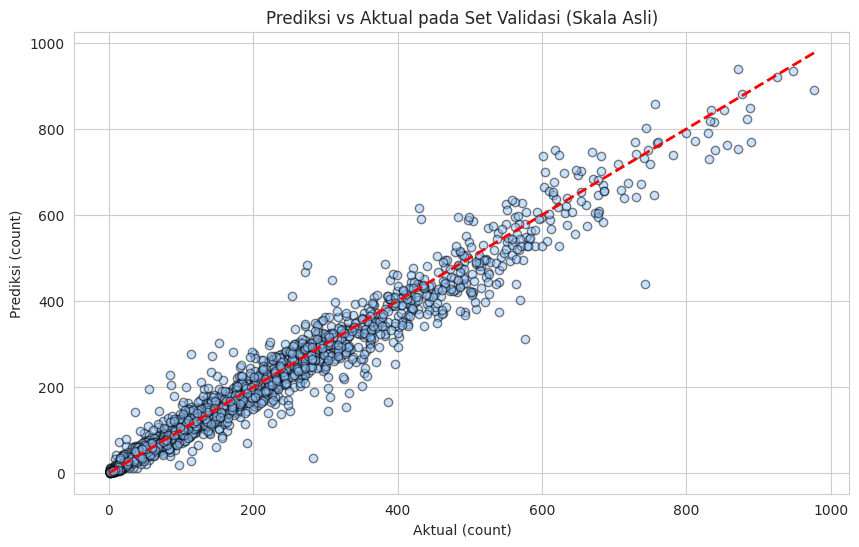

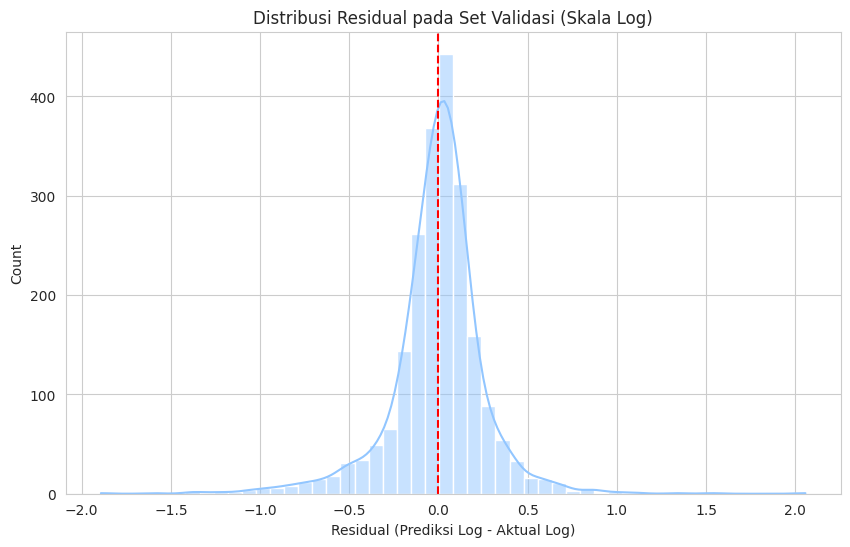

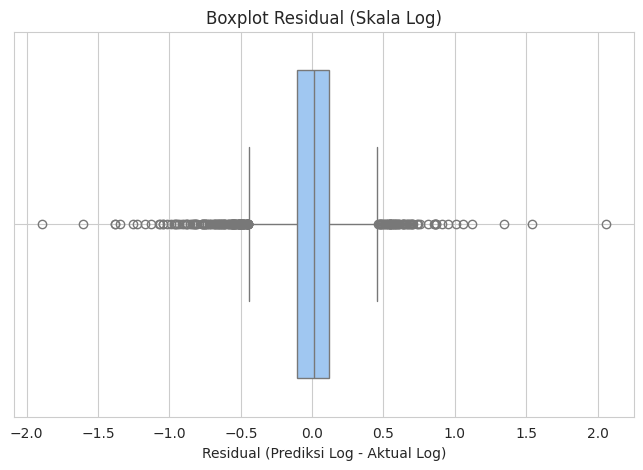

In [17]:
import numpy as np # Pastikan numpy sudah diimpor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt # Pastikan matplotlib sudah diimpor
import seaborn as sns # Pastikan seaborn sudah diimpor

if 'final_trained_pipeline' in locals() and 'X_val_engineered' in locals() and 'y_val' in locals() and 'y_val_original' in locals():
    print("\nMengevaluasi model final pada set validasi...")

    # Lakukan prediksi pada X_val_engineered
    # y_val adalah target dalam skala log, jadi prediksi juga akan dalam skala log
    y_val_pred_log_final = final_trained_pipeline.predict(X_val_engineered)

    # 1. Evaluasi pada Skala Log (y_val vs y_val_pred_log_final)
    val_rmse_log_final = np.sqrt(mean_squared_error(y_val, y_val_pred_log_final))
    val_mae_log_final = mean_absolute_error(y_val, y_val_pred_log_final)
    val_r2_log_final = r2_score(y_val, y_val_pred_log_final)

    print("\n--- Metrik Evaluasi Final pada Skala Log ---")
    print(f"Validation RMSE (log): {val_rmse_log_final:.4f}")
    print(f"Validation MAE (log): {val_mae_log_final:.4f}")
    print(f"Validation R2 (log): {val_r2_log_final:.4f}")

    # 2. Transformasi Balik Prediksi dan Nilai Aktual untuk Metrik Skala Asli
    # y_val_original sudah kita simpan sebelumnya (np.expm1(y_val))
    y_val_pred_original_final = np.expm1(y_val_pred_log_final)
    # Pastikan tidak ada nilai negatif setelah expm1 jika model memprediksi nilai log yang sangat kecil atau negatif
    y_val_pred_original_final = np.maximum(0, y_val_pred_original_final)

    # Hitung MAPE dan RMSLE pada skala asli
    val_mape_original_final = mean_absolute_percentage_error(y_val_original, y_val_pred_original_final)

    # Fungsi RMSLE jika belum terdefinisi di sel sebelumnya
    def rmsle_original(y_true_orig, y_pred_orig):
        # Tambahkan penanganan untuk y_pred_orig negatif jika np.log1p akan digunakan di dalamnya
        # atau pastikan y_pred_orig tidak negatif sebelum masuk ke mean_squared_log_error
        y_pred_safe = np.maximum(0, y_pred_orig)
        return np.sqrt(mean_squared_log_error(y_true_orig, y_pred_safe))

    val_rmsle_original_final = rmsle_original(y_val_original, y_val_pred_original_final)

    # Hitung juga MAE, MSE, RMSE pada skala asli untuk perbandingan
    val_mae_original_final = mean_absolute_error(y_val_original, y_val_pred_original_final)
    val_mse_original_final = mean_squared_error(y_val_original, y_val_pred_original_final)
    val_rmse_original_final = np.sqrt(val_mse_original_final)
    val_r2_original_final = r2_score(y_val_original, y_val_pred_original_final)


    print("\n--- Metrik Evaluasi Final pada Skala Asli (setelah inverse transform) ---")
    print(f"Validation MAE (original): {val_mae_original_final:.4f}")
    print(f"Validation MSE (original): {val_mse_original_final:.4f}")
    print(f"Validation RMSE (original): {val_rmse_original_final:.4f}")
    print(f"Validation R2 (original): {val_r2_original_final:.4f}")
    print(f"Validation MAPE (original): {val_mape_original_final:.4f} ({val_mape_original_final*100:.2f}%)")
    print(f"Validation RMSLE (original): {val_rmsle_original_final:.4f}")


    # 3. Plot Prediksi vs Aktual (skala asli)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val_original, y_val_pred_original_final, alpha=0.5, edgecolor='k')
    plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
    plt.xlabel('Aktual (count)')
    plt.ylabel('Prediksi (count)')
    plt.title('Prediksi vs Aktual pada Set Validasi (Skala Asli)')
    plt.grid(True)
    plt.show()

    # 4. Plot Residual (skala log, karena model dilatih pada skala log)
    residuals_log_final = y_val - y_val_pred_log_final
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals_log_final, kde=True, bins=50)
    plt.xlabel('Residual (Prediksi Log - Aktual Log)')
    plt.title('Distribusi Residual pada Set Validasi (Skala Log)')
    plt.grid(True)
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

    # Boxplot residual (skala log)
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=residuals_log_final)
    plt.title('Boxplot Residual (Skala Log)')
    plt.xlabel('Residual (Prediksi Log - Aktual Log)')
    plt.grid(True)
    plt.show()

else:
    print("Pipeline final terlatih (`final_trained_pipeline`) atau data validasi (`X_val_engineered`, `y_val`, `y_val_original`) belum siap.")

## 8. Penyimpanan Model Final (Pipeline Lengkap)

Model final yang telah dilatih dan dievaluasi (`final_trained_pipeline`) sekarang akan disimpan menggunakan `pickle`. File `.pkl` ini akan berisi keseluruhan pipeline pra-pemrosesan Scikit-learn dan model XGBoost yang sudah di-tuning, siap untuk digunakan dalam aplikasi Streamlit.

In [18]:
import pickle # Pastikan pickle sudah diimpor
from google.colab import files # Untuk download dari Colab

if 'final_trained_pipeline' in locals() and final_trained_pipeline is not None:
    # Anda bisa menyesuaikan nama file model jika diperlukan
    nama_file_model_final_pickle = 'XGBoost_SKLearn_Pipeline_Final.pkl'

    print(f"\nMenyimpan pipeline Scikit-learn final sebagai: {nama_file_model_final_pickle} menggunakan pickle...")
    with open(nama_file_model_final_pickle, 'wb') as file:
        pickle.dump(final_trained_pipeline, file)
    print(f"Model (pipeline scikit-learn final) berhasil disimpan sebagai: {nama_file_model_final_pickle}")

    # Tawarkan untuk mengunduh file model dari Colab
    print(f"\nMengunduh file: {nama_file_model_final_pickle}...")
    files.download(nama_file_model_final_pickle)
else:
    print("Variabel 'final_trained_pipeline' belum terdefinisi. Model tidak disimpan.")
    print("Pastikan sel pelatihan dan tuning model (Sel 23) telah berjalan dengan sukses dan menghasilkan 'final_trained_pipeline'.")


Menyimpan pipeline Scikit-learn final sebagai: XGBoost_SKLearn_Pipeline_Final.pkl menggunakan pickle...
Model (pipeline scikit-learn final) berhasil disimpan sebagai: XGBoost_SKLearn_Pipeline_Final.pkl

Mengunduh file: XGBoost_SKLearn_Pipeline_Final.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>